In [194]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [195]:
set.seed(1234)
options(digits=2)
stats <- c()

In [196]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 32)

In [197]:
if(!exists("papermill_run")) {
    prj_name = "Screen1"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
    de_testing = "NEIGHBORHOOD"
    filter_low_cas9 = "NO"
}

In [198]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as vector_positive, all others as target_negative

In [199]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "target_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "vector_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [200]:
if(prj_name == "Screen1") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")
} else if(prj_name == "Screen2") {
    df_guide = read.table("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
    integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
    neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S2/scripts/library_csv/neighbors_list.rds")
}

sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [201]:
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')
seurat_combined$sct_cas9 = seurat_combined[['SCT']]@data['dCas9',]

Validating h5Seurat file



Warning message:
"Adding a command log without an assay associated with it"


In [202]:
df_sct_cas9 = data.frame(seurat_combined$sct_cas9)
colnames(df_sct_cas9) = c("Normalized_dCas9_expression")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


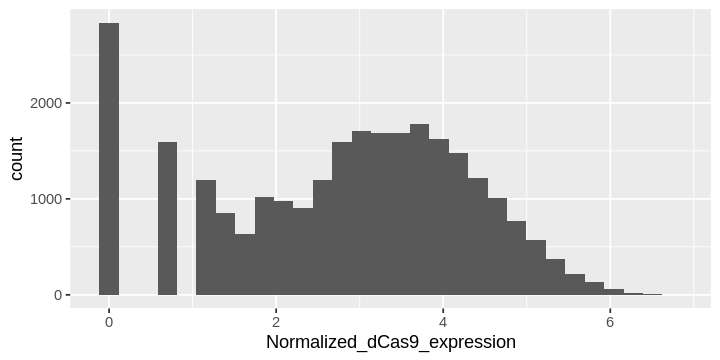

In [203]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(df_sct_cas9, aes(Normalized_dCas9_expression)) +
    geom_histogram()

#cells before dCas9 filtering 27142

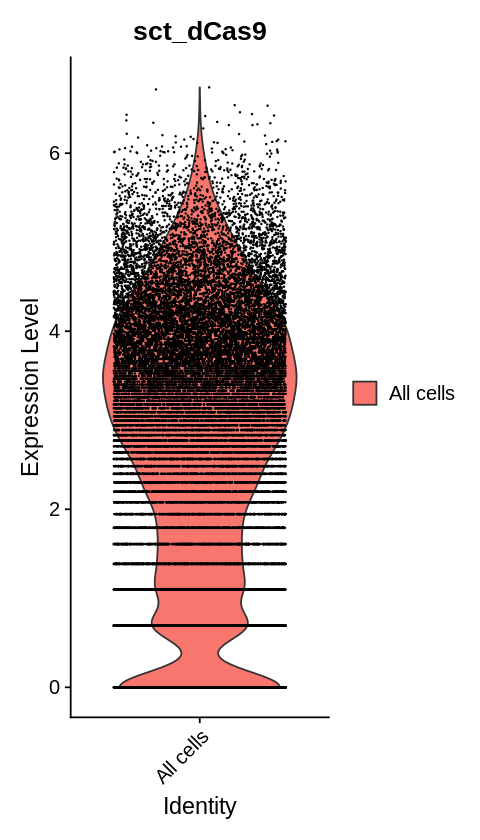

In [204]:
options(repr.plot.width = 4, repr.plot.height = 7)
Idents(seurat_combined) <- "All cells"
VlnPlot(seurat_combined, assay = 'SCT', features = "sct_dCas9")
n_cells = length(Cells(seurat_combined))
cat("#cells before dCas9 filtering", n_cells)

In [205]:
if(filter_low_cas9 == "YES") {
    seurat_combined = subset(seurat_combined, subset=sct_cas9 > 0)
    plt = VlnPlot(seurat_combined, assay = 'SCT', features = "sct_dCas9")
    n_cells = length(Cells(seurat_combined))
    cat("#cells after dCas9 filtering", n_cells)
    print(plt)
}

Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [206]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [207]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [208]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [209]:
THRESHOLD_MULTIPLIER = 1
cat(red("Using ", THRESHOLD_MULTIPLIER, "x threshold"))

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using  1 x threshold

In [210]:
length(perturbed_cells_by_guide[[3]])

[1] 796

In [211]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

# Check DE for genes near SNPs

In [212]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

## Load neighbors list

# Run diffex on pseudobulked samples using EdgeR

This version ran DE testing on all genes. If you want to include only the neighbors, use: markers <- qlf$table[neighbors, ] %>% arrange(PValue)

In [213]:
library(edgeR)

In [214]:
sample_n(df_guide, 5)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs4669722,DE10-1a,DE10-1b,DE10,ckd_de,targeting,rs4669722,CKD DE
CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
rs34861762,DE7-2a,DE7-2b,DE7,ckd_de,targeting,rs34861762,CKD DE
GDOC3,GDOC3-1a,GDOC3-1b,GDOC3,gdoc,nt_ctrl,GDOC3,gdoc
rs7642977,DE2-1a,DE2-1b,DE2,ckd_de,targeting,rs7642977,CKD DE


### This is the loop before refactoring

ANPEP ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 

donor0 donor1 donor2 donor3 
   270    233    385    273 
  logFC logCPM    F   PValue de_gene target subclass       label
1 -1.32    6.9 1122 2.6e-207   ANPEP  ANPEP      tss Control TSS
2 -0.33    6.7   76  2.5e-18    IDH2  ANPEP      tss Control TSS
3 -0.20    6.7   27  1.8e-07  SEMA4B  ANPEP      tss Control TSS
4  0.23    5.4   23  1.5e-06   AP3S2  ANPEP      tss Control TSS
5  0.21    5.4   19  1.5e-05   MFGE8  ANPEP      tss Control TSS
6 -0.36    3.5   15  1.2e-04   FANCI  ANPEP      tss Control TSS
-------------------------------------------------------

CD55 CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26061 

donor0 donor1 donor2 donor3 
   253    220    319    289 


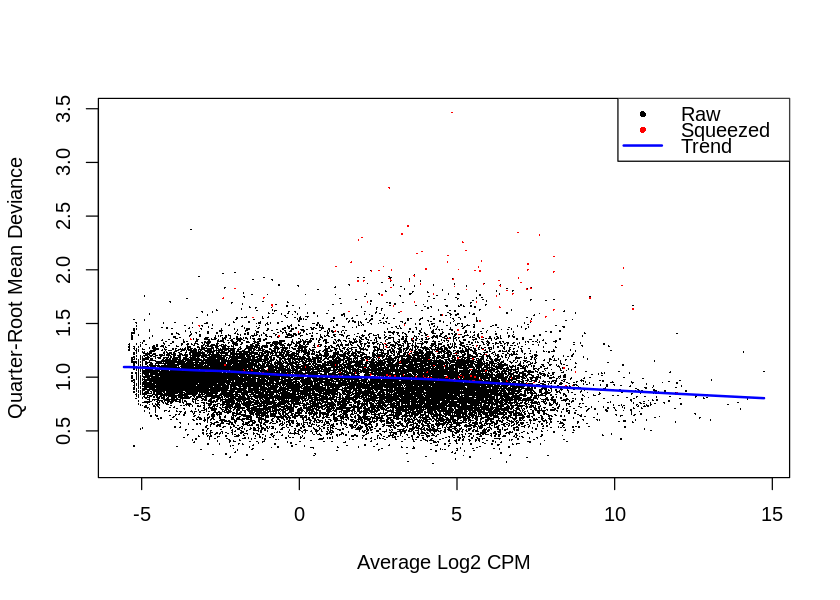

  logFC logCPM     F  PValue  de_gene target subclass       label
1 -2.20    4.1 432.1 8.8e-96     CD55   CD55      tss Control TSS
2 -0.32    2.6   6.2 1.3e-02 C1orf116   CD55      tss Control TSS
3 -0.28    2.9   5.9 1.5e-02    IKBKE   CD55      tss Control TSS
4 -0.18    4.0   5.3 2.1e-02    EIF2D   CD55      tss Control TSS
5  1.86   -3.9   3.7 5.4e-02      CR2   CD55      tss Control TSS
6  0.18    3.1   3.3 6.9e-02    DYRK3   CD55      tss Control TSS
-------------------------------------------------------

NT5E NT5E : CD73-1a,CD73-1b 
CD73-1a   757 
CD73-1b   1020 
Guide+ = 1020 ; Guide- = 26122 

donor0 donor1 donor2 donor3 
   231    215    337    237 


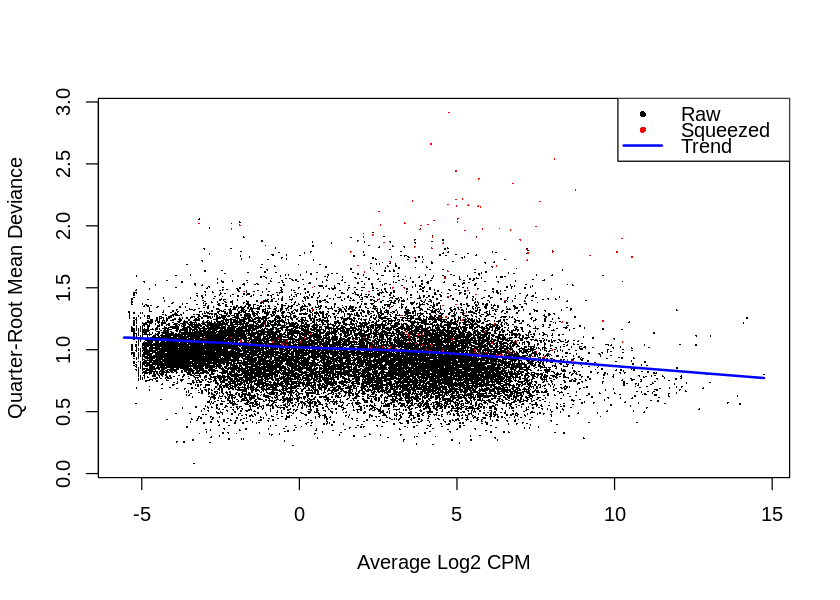

   logFC logCPM       F   PValue   de_gene target subclass       label
1 -1.848    6.4 1290.77 6.0e-165      NT5E   NT5E      tss Control TSS
2  0.081    6.1    3.25  7.2e-02 LINC01611   NT5E      tss Control TSS
3 -0.371    0.5    1.70  1.9e-01 LINC02535   NT5E      tss Control TSS
4  0.032    8.4    0.97  3.3e-01     SNHG5   NT5E      tss Control TSS
5  0.076    2.1    0.25  6.2e-01     TBX18   NT5E      tss Control TSS
6 -0.016    6.2    0.13  7.2e-01     SNX14   NT5E      tss Control TSS
-------------------------------------------------------

FUBP1 FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   708 
FUBP1-1b   925 
Guide+ = 925 ; Guide- = 26217 

donor0 donor1 donor2 donor3 
   229    166    282    248 


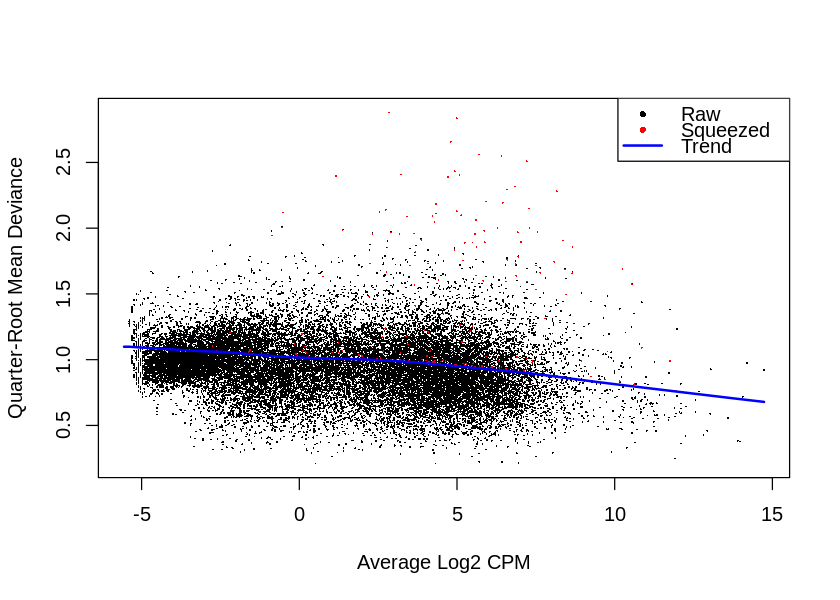

  logFC logCPM     F  PValue de_gene target subclass       label
1 -0.86    5.6 246.5 5.1e-55   FUBP1  FUBP1      tss Control TSS
2 -0.18    7.4  25.2 5.1e-07     AK5  FUBP1      tss Control TSS
3 -0.56    2.5  14.6 1.3e-04   PTGFR  FUBP1      tss Control TSS
4 -0.21    4.6   9.1 2.5e-03  ADGRL4  FUBP1      tss Control TSS
5  0.31    3.0   8.5 3.6e-03  DNAJB4  FUBP1      tss Control TSS
6 -0.13    6.0   7.8 5.1e-03   USP33  FUBP1      tss Control TSS
-------------------------------------------------------

C15orf40 C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   822 
C15orf40-1b   1076 
Guide+ = 1076 ; Guide- = 26066 

donor0 donor1 donor2 donor3 
   274    210    323    269 


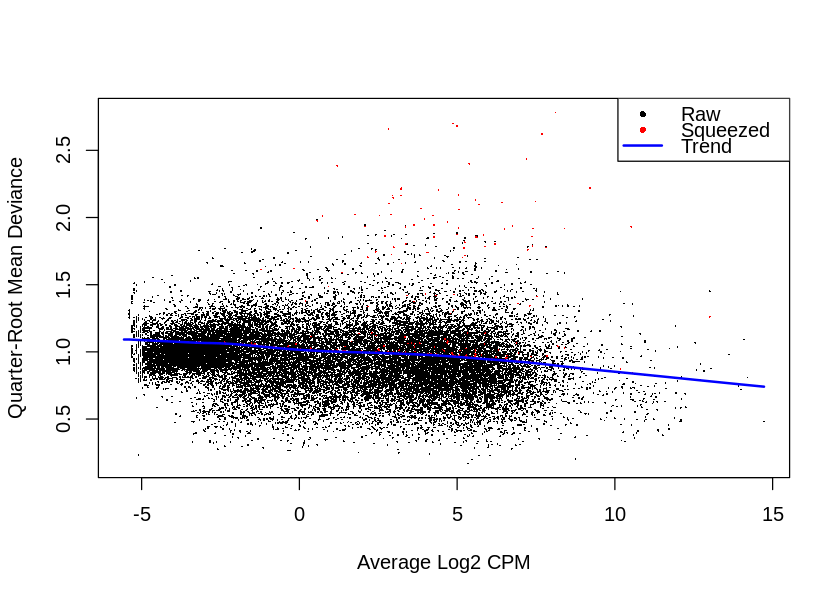

   logFC logCPM     F   PValue  de_gene   target subclass       label
1 -2.135    4.9 790.1 3.1e-173 C15orf40 C15orf40      tss Control TSS
2 -0.416    3.0  13.2  2.8e-04 ADAMTSL3 C15orf40      tss Control TSS
3  0.427    1.6   6.8  9.2e-03    CPEB1 C15orf40      tss Control TSS
4 -0.425    1.8   6.0  1.5e-02   SNHG21 C15orf40      tss Control TSS
5 -0.121    4.6   3.5  6.3e-02   HDGFL3 C15orf40      tss Control TSS
6  0.035   10.7   2.1  1.4e-01    RPS17 C15orf40      tss Control TSS
-------------------------------------------------------

MAFF MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   664 
MAFF-1b   869 
Guide+ = 869 ; Guide- = 26273 

donor0 donor1 donor2 donor3 
   219    185    256    209 


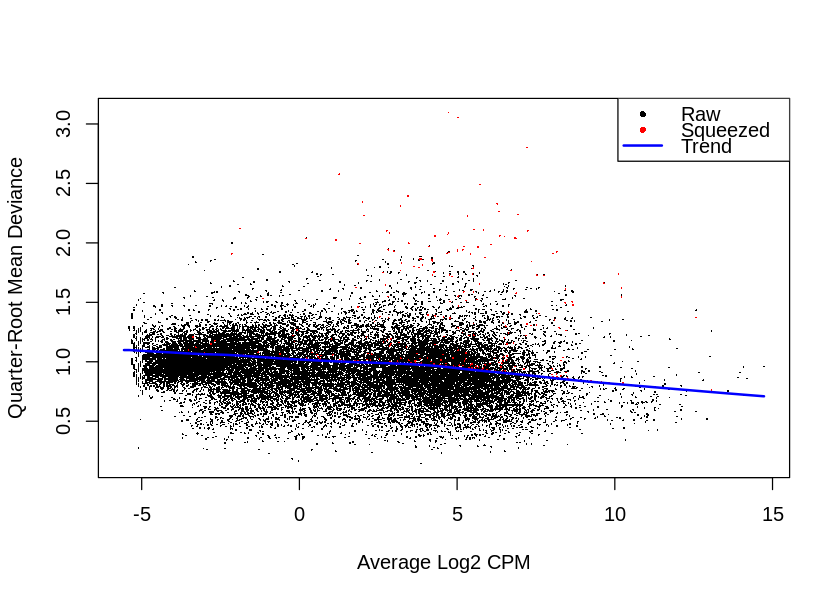

  logFC logCPM   F  PValue de_gene target subclass       label
1 -1.82   3.37 167 3.5e-38    MAFF   MAFF      tss Control TSS
2 -0.19  10.47  58 2.7e-14  LGALS1   MAFF      tss Control TSS
3 -1.33   1.15  21 3.8e-06  LGALS2   MAFF      tss Control TSS
4 -0.46   3.67  20 6.1e-06    GCAT   MAFF      tss Control TSS
5 -0.18   6.22  14 1.5e-04   EIF3L   MAFF      tss Control TSS
6 -1.50   0.22  13 2.6e-04    DMC1   MAFF      tss Control TSS
-------------------------------------------------------

FTH1 FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   625 
FTH1-2a   3329 
FTH1-1b   3502 
FTH1-2b   3502 
Guide+ = 3502 ; Guide- = 23640 

donor0 donor1 donor2 donor3 
   843    789   1037    833 


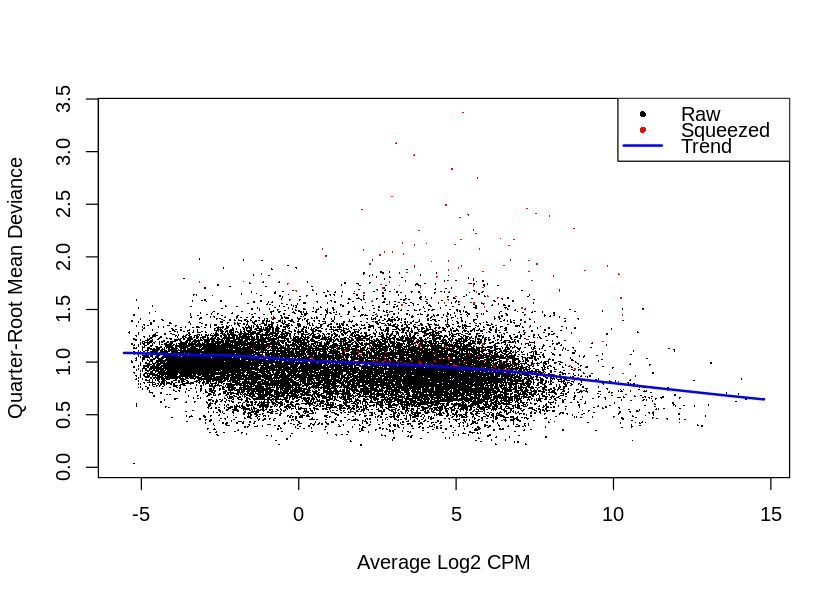

  logFC logCPM   F  PValue de_gene target   subclass      label
1 -0.52   14.0 834 2.5e-93    FTH1   FTH1 de_control Control DE
2 -0.41    4.7 109 1.6e-25   FADS2   FTH1 de_control Control DE
3 -0.21    8.3  85 3.3e-20   AHNAK   FTH1 de_control Control DE
4 -0.52    3.5  80 4.6e-19   BEST1   FTH1 de_control Control DE
5  0.24    6.5  78 1.4e-18  SLC3A2   FTH1 de_control Control DE
6 -0.25    6.0  73 1.4e-17  ASRGL1   FTH1 de_control Control DE
-------------------------------------------------------

PLIN3 PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   863 
PLIN3-2a   1582 
PLIN3-1b   1817 
PLIN3-2b   2056 
Guide+ = 2056 ; Guide- = 25086 

donor0 donor1 donor2 donor3 
   476    425    651    504 


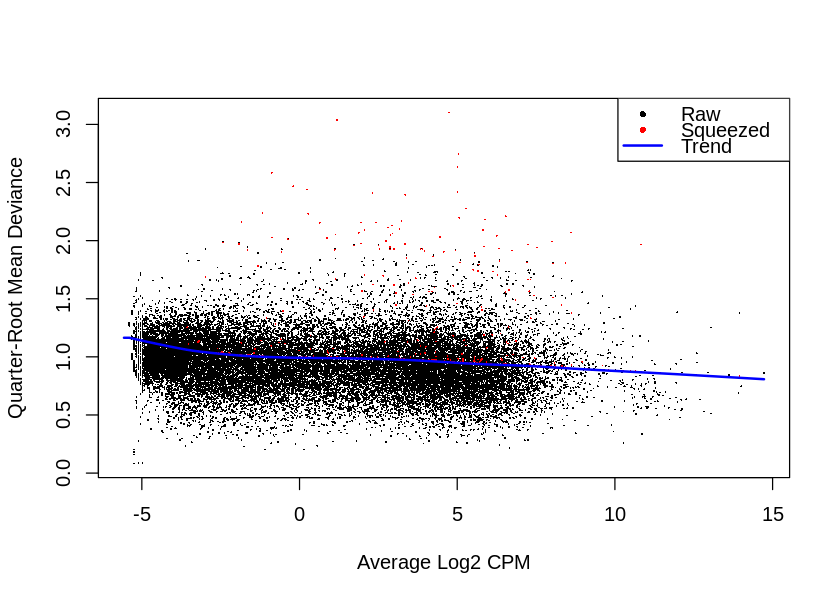

  logFC logCPM   F   PValue   de_gene target   subclass      label
1 -0.95    6.3 802 9.8e-176     PLIN3  PLIN3 de_control Control DE
2 -0.85    2.3  52  5.7e-13     UHRF1  PLIN3 de_control Control DE
3  0.14   11.2  46  1.2e-11     RPL36  PLIN3 de_control Control DE
4  0.20    4.6  19  1.5e-05      DPP9  PLIN3 de_control Control DE
5 -0.49    2.0  16  5.3e-05 TNFAIP8L1  PLIN3 de_control Control DE
6 -0.18    4.8  15  8.7e-05    HDGFL2  PLIN3 de_control Control DE
-------------------------------------------------------

TKT TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   674 
TKT-2a   1496 
TKT-1b   1706 
TKT-2b   1976 
Guide+ = 1976 ; Guide- = 25166 

donor0 donor1 donor2 donor3 
   475    422    612    467 


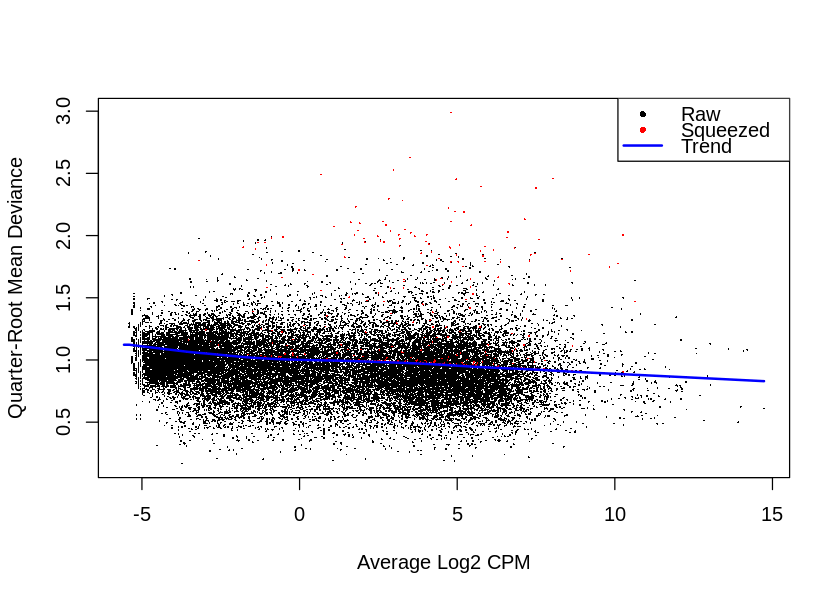

   logFC logCPM     F   PValue de_gene target   subclass      label
1 -0.699    8.2 632.3 3.9e-139     TKT    TKT de_control Control DE
2 -0.301    3.8  21.9  3.0e-06 CACNA1D    TKT de_control Control DE
3 -0.191    4.3  12.8  3.4e-04  NT5DC2    TKT de_control Control DE
4 -0.132    4.8   8.3  3.9e-03  GLT8D1    TKT de_control Control DE
5  0.736   -1.0   6.5  1.1e-02   ITIH4    TKT de_control Control DE
6 -0.085    5.0   4.0  4.6e-02   DCP1A    TKT de_control Control DE
-------------------------------------------------------

LGALS3 LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   912 
LGALS3-2a   1656 
LGALS3-1b   1890 
LGALS3-2b   2116 
Guide+ = 2116 ; Guide- = 25026 

donor0 donor1 donor2 donor3 
   542    405    646    523 


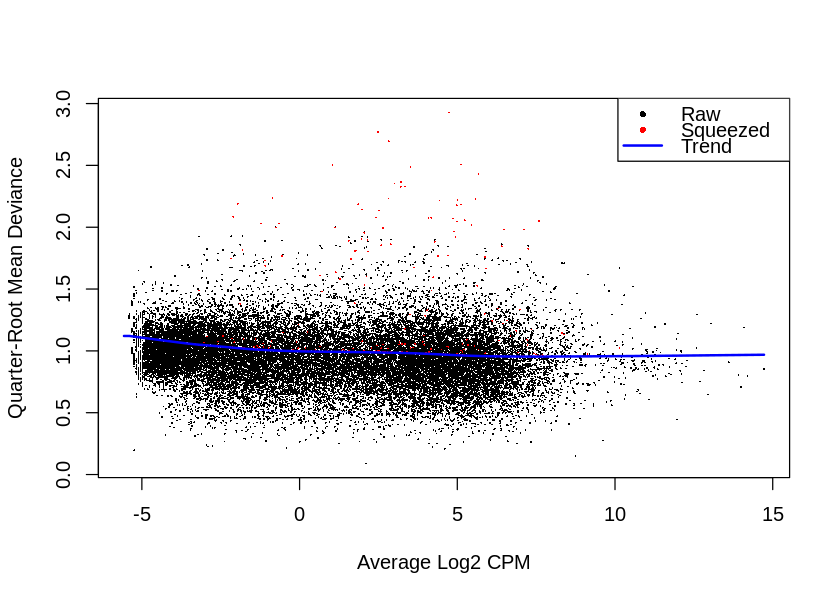

  logFC logCPM      F  PValue   de_gene target   subclass      label
1 -1.29    7.9 2409.0 0.0e+00    LGALS3 LGALS3 de_control Control DE
2 -0.86    3.7  146.0 8.8e-31    DLGAP5 LGALS3 de_control Control DE
3 -0.74    4.2  135.8 9.3e-22     CDKN3 LGALS3 de_control Control DE
4 -0.33    3.5   21.8 3.1e-06     WDHD1 LGALS3 de_control Control DE
5  0.16    3.9    7.8 5.2e-03    CGRRF1 LGALS3 de_control Control DE
6  0.93   -1.5    7.7 5.5e-03 LINC00520 LGALS3 de_control Control DE
-------------------------------------------------------

CSTB CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   968 
CSTB-2a   1831 
CSTB-1b   2085 
CSTB-2b   2337 
Guide+ = 2337 ; Guide- = 24805 

donor0 donor1 donor2 donor3 
   543    493    713    588 


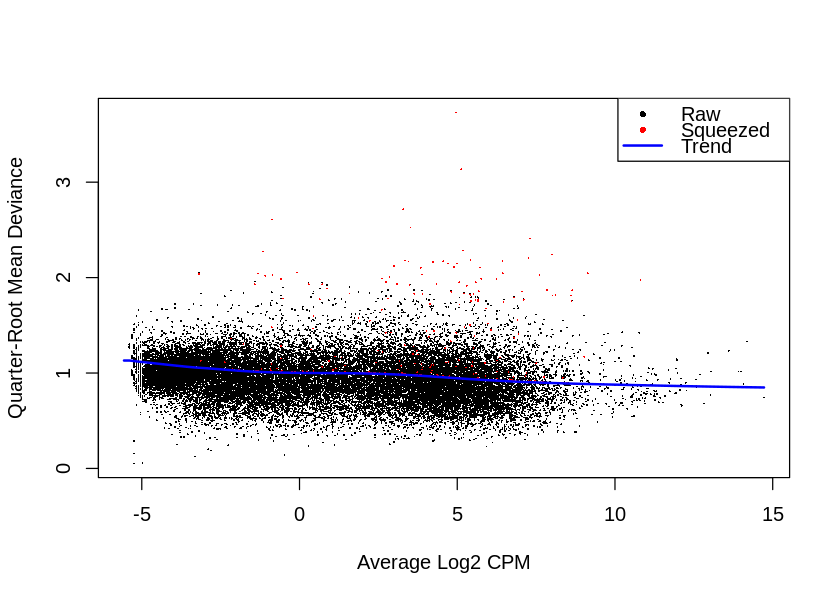

  logFC logCPM     F  PValue  de_gene target   subclass      label
1 -0.41    8.3 268.0 3.7e-60     CSTB   CSTB de_control Control DE
2 -0.22    6.6  55.5 9.4e-14     PDXK   CSTB de_control Control DE
3 -0.12    5.0   8.1 4.5e-03     PFKL   CSTB de_control Control DE
4 -5.13   -4.0   4.2 3.9e-02    AATBC   CSTB de_control Control DE
5 -2.43   -3.4   4.1 4.3e-02 ERVH48-1   CSTB de_control Control DE
6 -4.94   -4.1   3.7 5.6e-02    TRPM2   CSTB de_control Control DE
-------------------------------------------------------

CTSB CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   998 
CTSB-2a   1793 
CTSB-1b   2028 
CTSB-2b   2222 
Guide+ = 2222 ; Guide- = 24920 

donor0 donor1 donor2 donor3 
   540    454    668    560 


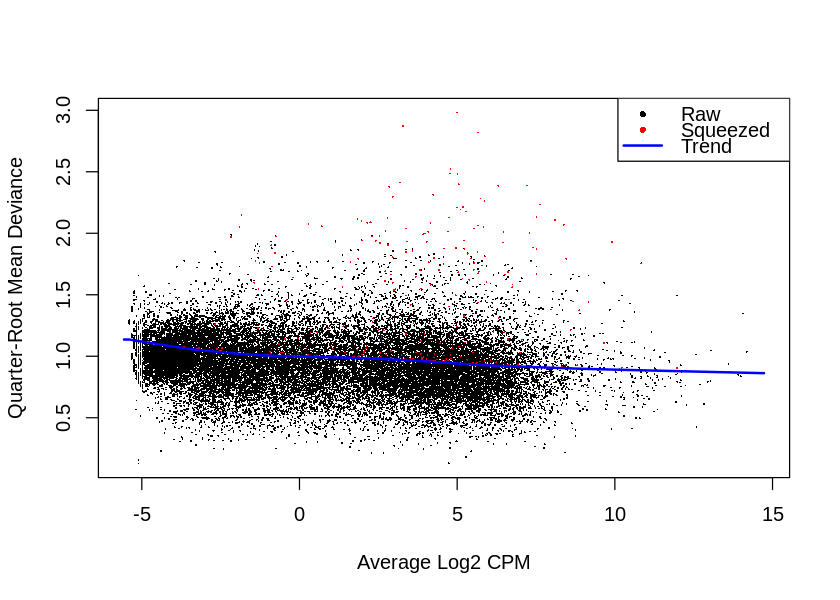

   logFC logCPM      F   PValue   de_gene target   subclass      label
1 -0.901    8.7 1611.7 8.8e-302      CTSB   CTSB de_control Control DE
2 -0.305    6.3   95.9  1.2e-22     FDFT1   CTSB de_control Control DE
3  0.316    1.8    7.8  5.4e-03    FAM66D   CTSB de_control Control DE
4 -4.481   -4.4    2.4  1.2e-01 LINC00681   CTSB de_control Control DE
5  0.077    4.3    2.4  1.2e-01     MTMR9   CTSB de_control Control DE
6 -0.762   -2.1    2.1  1.5e-01   FAM86B2   CTSB de_control Control DE
-------------------------------------------------------

KLF6 KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   879 
KLF6-2a   1728 
KLF6-1b   1982 
KLF6-2b   2193 
Guide+ = 2193 ; Guide- = 24949 

donor0 donor1 donor2 donor3 
   526    462    667    538 


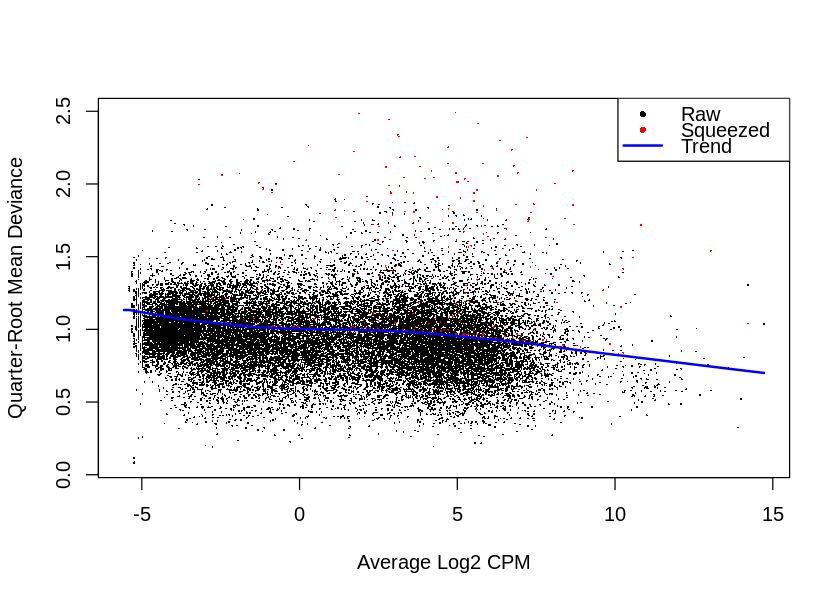

  logFC logCPM     F  PValue   de_gene target   subclass      label
1 -0.37    7.8 263.3 1.1e-54      KLF6   KLF6 de_control Control DE
2 -0.19    6.9  55.9 7.7e-14      PFKP   KLF6 de_control Control DE
3  0.31    1.1   4.6 3.3e-02     MANCR   KLF6 de_control Control DE
4 -1.11   -2.3   3.3 6.9e-02 LINC00705   KLF6 de_control Control DE
5 -4.54   -4.4   2.5 1.2e-01 LINC02668   KLF6 de_control Control DE
6 -3.83   -4.8   1.4 2.3e-01 LINC02660   KLF6 de_control Control DE
-------------------------------------------------------

DE1 DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   862 
DE1-2a   1745 
DE1-1b   1973 
DE1-2b   2238 
Guide+ = 2238 ; Guide- = 24904 

donor0 donor1 donor2 donor3 
   494    490    683    571 


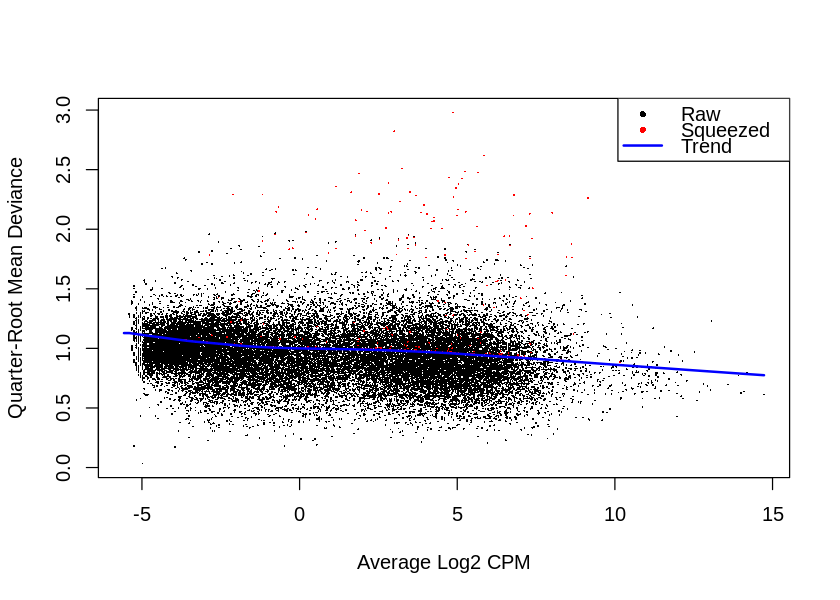

   logFC logCPM    F  PValue   de_gene target subclass  label
1  0.130    7.7 24.4 7.8e-07     NRIP1    DE1   ckd_de CKD DE
2 -0.156    5.2 15.5 8.1e-05  MIR99AHG    DE1   ckd_de CKD DE
3  0.221    3.4 11.4 7.5e-04    HSPA13    DE1   ckd_de CKD DE
4  0.206    3.3  9.2 2.4e-03 LINC02246    DE1   ckd_de CKD DE
5  0.042    6.4  1.9 1.7e-01     USP25    DE1   ckd_de CKD DE
6  0.510   -2.4  1.1 2.9e-01      LIPI    DE1   ckd_de CKD DE
-------------------------------------------------------

DE2 DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   938 
DE2-1b   938 
DE2-2b   1232 
Guide+ = 1232 ; Guide- = 25910 

donor0 donor1 donor2 donor3 
   294    243    385    310 


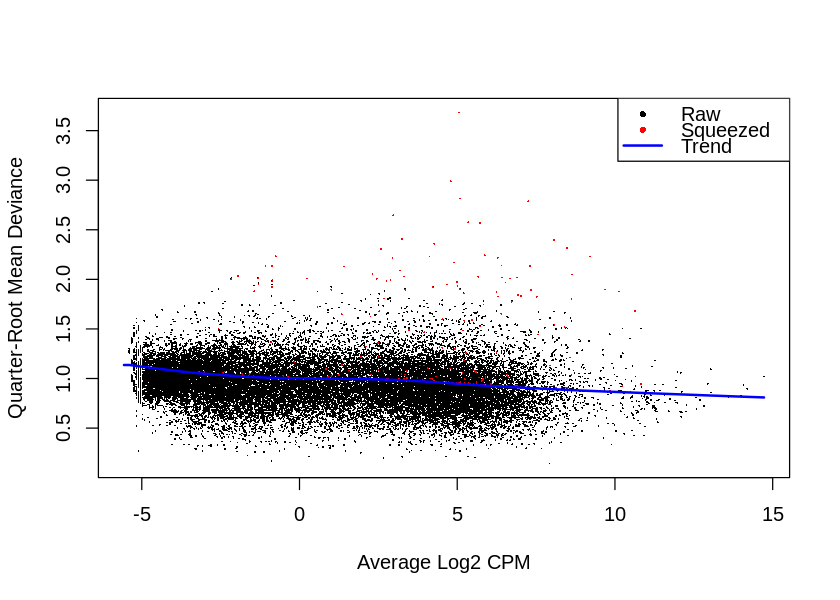

  logFC logCPM    F  PValue   de_gene target subclass  label
1  1.61  -1.97 12.8 0.00035 LINC02028    DE2   ckd_de CKD DE
2 -0.12   6.52 11.5 0.00071   ATP13A3    DE2   ckd_de CKD DE
3 -0.13   5.85  9.7 0.00181      HES1    DE2   ckd_de CKD DE
4  0.62   0.70  9.5 0.00204    PLAAT1    DE2   ckd_de CKD DE
5 -0.57   0.95  6.3 0.01241 LINC00887    DE2   ckd_de CKD DE
6 -0.21   3.43  5.5 0.01905    TMEM44    DE2   ckd_de CKD DE
-------------------------------------------------------

DE3 DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   959 
DE3-2a   1838 
DE3-1b   2110 
DE3-2b   2394 
Guide+ = 2394 ; Guide- = 24748 

donor0 donor1 donor2 donor3 
   535    513    785    561 


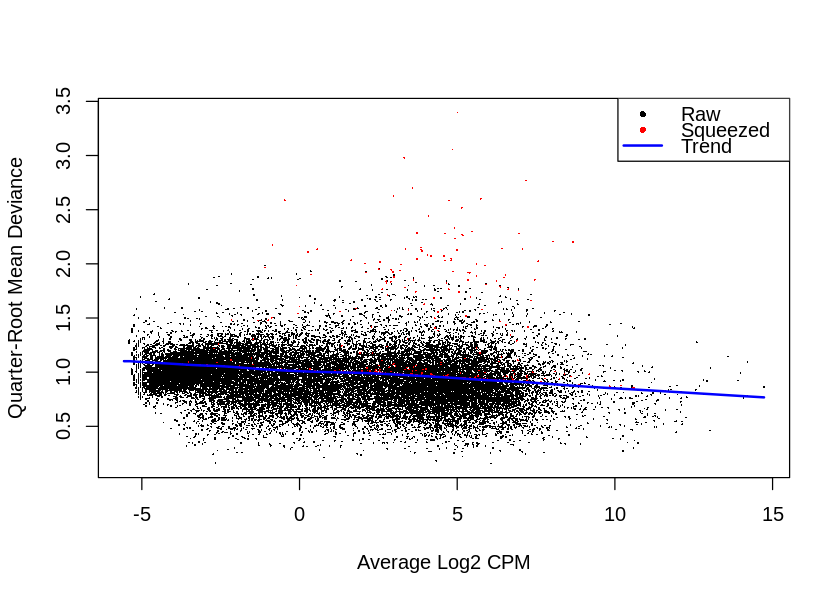

   logFC logCPM     F  PValue   de_gene target subclass  label
1  0.229    3.4 12.84 0.00034    HSPA13    DE3   ckd_de CKD DE
2 -0.055    7.6  3.75 0.05295     NRIP1    DE3   ckd_de CKD DE
3  0.125    3.3  3.48 0.06224 LINC02246    DE3   ckd_de CKD DE
4  0.048    6.4  2.42 0.12005     USP25    DE3   ckd_de CKD DE
5 -0.490   -2.4  0.80 0.37023      LIPI    DE3   ckd_de CKD DE
6 -0.239   -1.5  0.42 0.51614    SAMSN1    DE3   ckd_de CKD DE
-------------------------------------------------------

DE4 DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   1623 
DE4-2a   2295 
DE4-1b   2369 
DE4-2b   2547 
Guide+ = 2547 ; Guide- = 24595 

donor0 donor1 donor2 donor3 
   605    552    778    612 


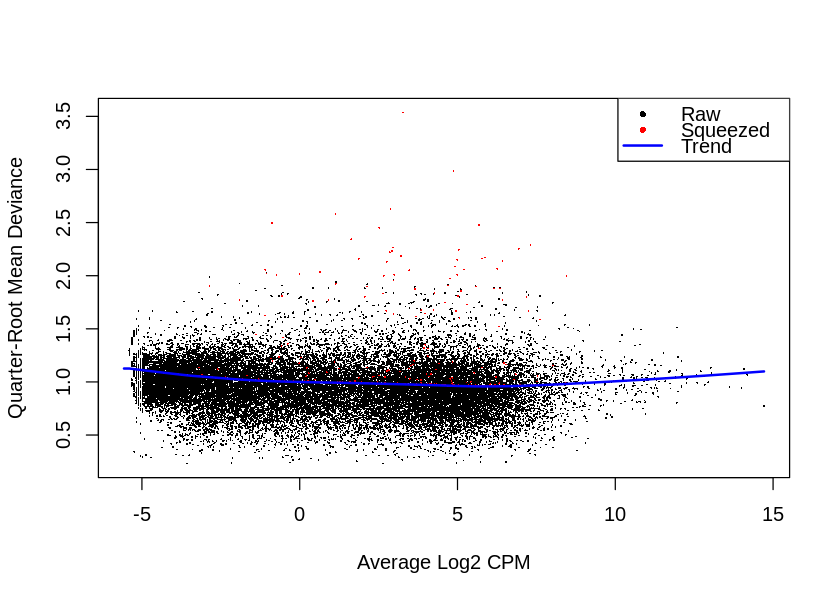

   logFC logCPM     F  PValue de_gene target subclass  label
1 -0.828    4.8 318.8 1.4e-58   CCNB1    DE4   ckd_de CKD DE
2 -0.233    3.2  10.6 1.1e-03   CENPH    DE4   ckd_de CKD DE
3 -0.073    6.3   6.2 1.3e-02  MRPS36    DE4   ckd_de CKD DE
4 -0.108    4.4   5.2 2.2e-02    CDK7    DE4   ckd_de CKD DE
5  0.087    4.7   4.2 4.0e-02   RAD17    DE4   ckd_de CKD DE
6 -0.062    5.5   3.2 7.4e-02     AK6    DE4   ckd_de CKD DE
-------------------------------------------------------

DE5 DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   1003 
DE5-2a   1965 
DE5-1b   2224 
DE5-2b   2475 
Guide+ = 2475 ; Guide- = 24667 

donor0 donor1 donor2 donor3 
   580    535    767    593 


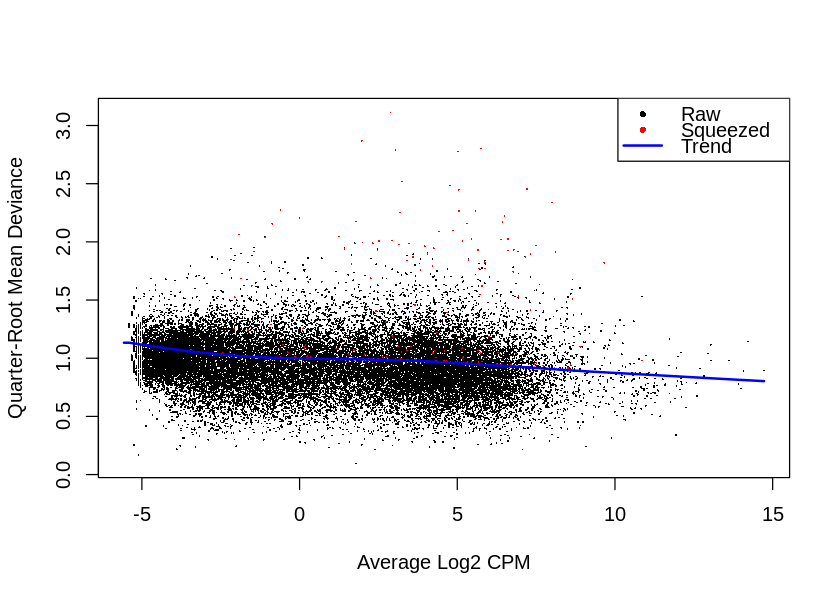

   logFC logCPM     F  PValue de_gene target subclass  label
1 -0.459    3.7 52.32 1.1e-12   CHST9    DE5   ckd_de CKD DE
2  0.138    3.6  5.17 2.3e-02   TAF4B    DE5   ckd_de CKD DE
3  2.093   -4.9  2.32 1.3e-01  PCAT18    DE5   ckd_de CKD DE
4  0.835   -3.7  1.15 2.8e-01   PSMA8    DE5   ckd_de CKD DE
5  0.039    5.2  1.09 3.0e-01   KCTD1    DE5   ckd_de CKD DE
6  0.034    5.4  0.96 3.3e-01    SS18    DE5   ckd_de CKD DE
-------------------------------------------------------

DE6 DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   896 
DE6-2a   2585 
DE6-1b   2828 
DE6-2b   2839 
Guide+ = 2839 ; Guide- = 24303 

donor0 donor1 donor2 donor3 
   699    583    836    721 


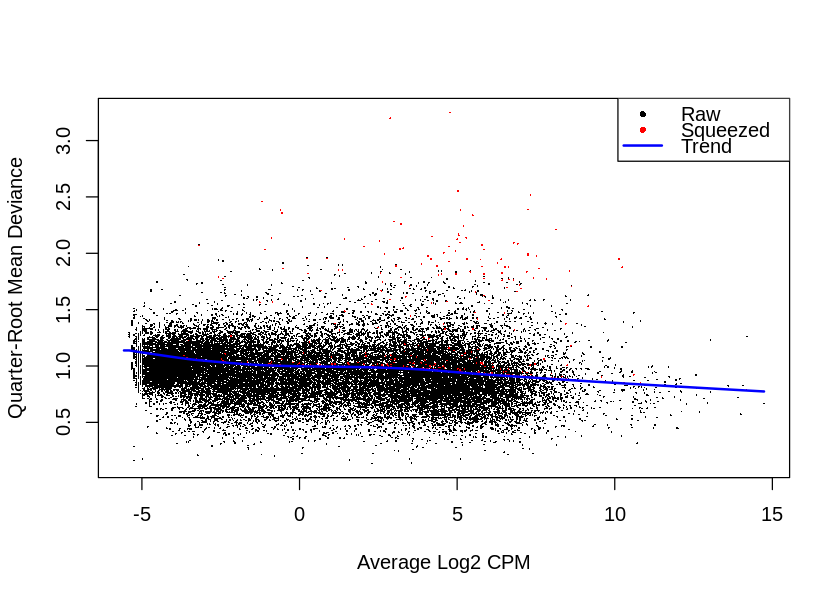

   logFC logCPM     F   PValue de_gene target subclass  label
1 -0.998   6.00 907.8 9.3e-171   NDRG1    DE6   ckd_de CKD DE
2  0.059   6.14   3.9  4.9e-02 PHF20L1    DE6   ckd_de CKD DE
3  0.142   2.53   3.0  8.1e-02      TG    DE6   ckd_de CKD DE
4  0.391  -0.62   2.9  9.0e-02  TMEM71    DE6   ckd_de CKD DE
5  0.571  -2.14   2.2  1.4e-01   HPYR1    DE6   ckd_de CKD DE
6  0.031   6.77   1.3  2.6e-01 ST3GAL1    DE6   ckd_de CKD DE
-------------------------------------------------------

DE7 DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   1010 
DE7-2a   1789 
DE7-1b   2057 
DE7-2b   2274 
Guide+ = 2274 ; Guide- = 24868 

donor0 donor1 donor2 donor3 
   512    480    723    559 


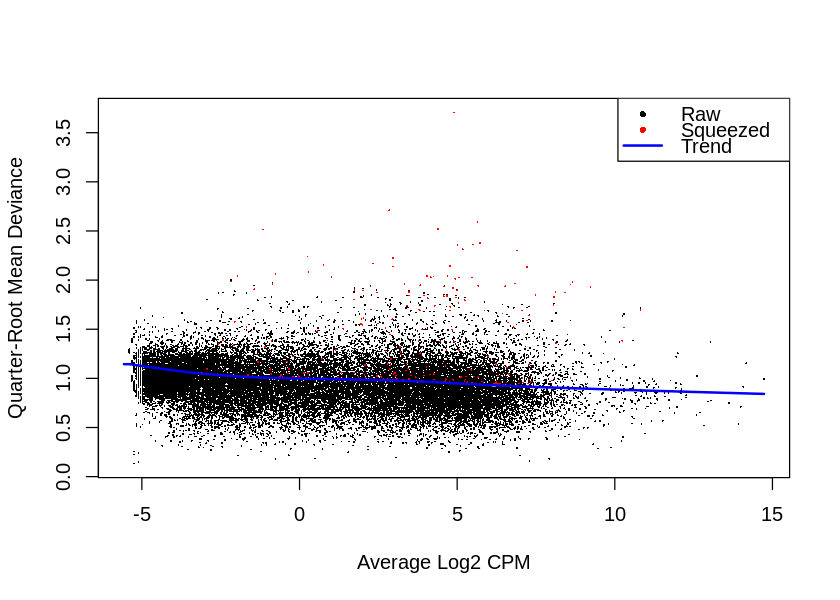

   logFC logCPM     F  PValue   de_gene target subclass  label
1 -0.562    4.9 163.2 2.5e-37      STC1    DE7   ckd_de CKD DE
2 -0.344    5.6  91.3 1.3e-21     LOXL2    DE7   ckd_de CKD DE
3 -0.584    2.9  46.2 1.1e-11    ADAM28    DE7   ckd_de CKD DE
4  0.184    6.6  43.0 5.5e-11 TNFRSF10B    DE7   ckd_de CKD DE
5  0.159    4.3  10.4 1.3e-03 TNFRSF10A    DE7   ckd_de CKD DE
6 -0.093    5.6   7.2 7.1e-03 TNFRSF10D    DE7   ckd_de CKD DE
-------------------------------------------------------

DE8 DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   974 
DE8-2a   1999 
DE8-1b   2320 
DE8-2b   2620 
Guide+ = 2620 ; Guide- = 24522 

donor0 donor1 donor2 donor3 
   617    574    805    624 


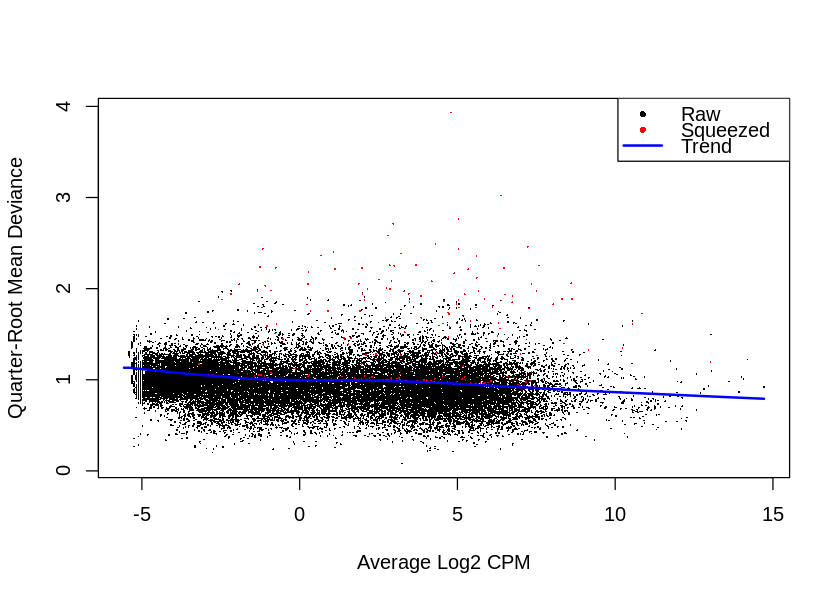

  logFC logCPM     F  PValue   de_gene target subclass  label
1 -0.20   5.70 39.52 3.3e-10  PPARGC1A    DE8   ckd_de CKD DE
2 -0.11   5.71 11.46 7.1e-04     DHX15    DE8   ckd_de CKD DE
3 -0.94  -3.89  0.72 4.0e-01 LINC02473    DE8   ckd_de CKD DE
4 -0.16  -0.53  0.44 5.1e-01    ERVH-1    DE8   ckd_de CKD DE
-------------------------------------------------------

DE9 DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   933 
DE9-2a   933 
DE9-1b   1296 
DE9-2b   1296 
Guide+ = 1296 ; Guide- = 25846 

donor0 donor1 donor2 donor3 
   264    288    412    332 


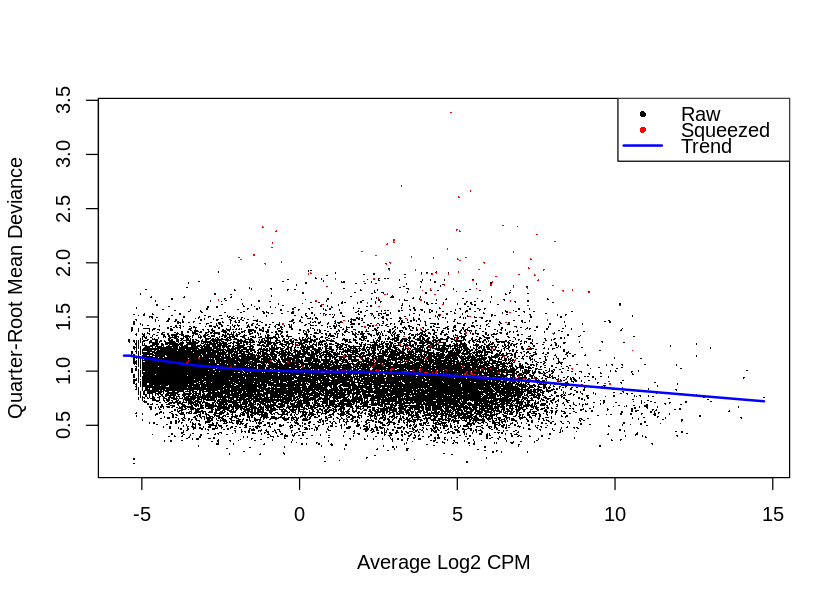

  logFC logCPM    F  PValue de_gene target subclass  label
1 -0.14    6.3 12.1 0.00051  SUPT3H    DE9   ckd_de CKD DE
2 -0.12    6.9 11.8 0.00060  MRPL14    DE9   ckd_de CKD DE
3 -0.10    6.7  7.3 0.00696   DNPH1    DE9   ckd_de CKD DE
4  0.11    6.0  7.0 0.00836   VEGFA    DE9   ckd_de CKD DE
5  0.21    3.5  6.8 0.00920  GTPBP2    DE9   ckd_de CKD DE
6  0.16    4.3  6.8 0.00928    POLH    DE9   ckd_de CKD DE
-------------------------------------------------------

DE10 DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   735 
DE10-2a   1490 
DE10-1b   1685 
DE10-2b   1929 
Guide+ = 1929 ; Guide- = 25213 

donor0 donor1 donor2 donor3 
   461    415    589    464 


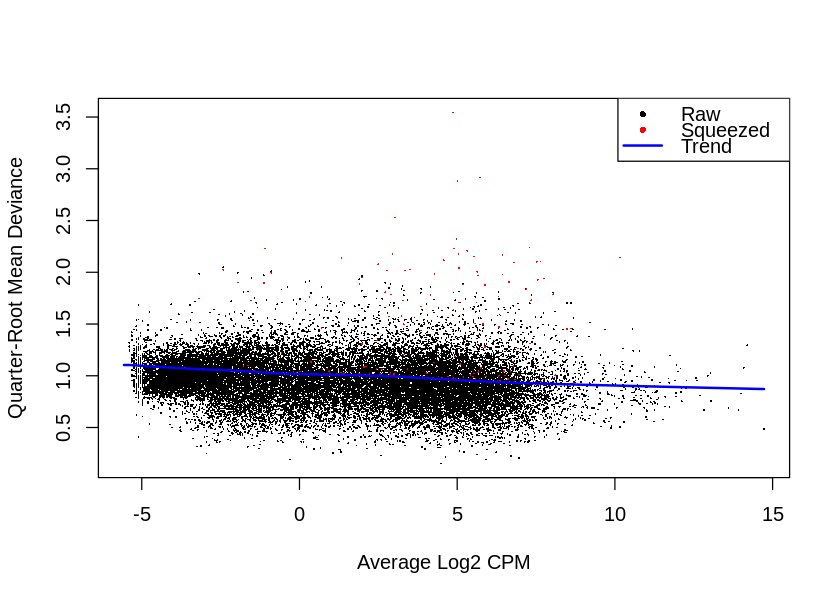

   logFC logCPM    F  PValue de_gene target subclass  label
1 -0.182    7.9 49.8 1.8e-12   PDIA6   DE10   ckd_de CKD DE
2 -0.127    5.8 12.4 4.3e-04  HPCAL1   DE10   ckd_de CKD DE
3  0.065    6.3  4.0 4.5e-02   ROCK2   DE10   ckd_de CKD DE
4  0.568   -1.6  2.2 1.4e-01   GREB1   DE10   ckd_de CKD DE
5 -0.062    4.9  1.9 1.7e-01   LPIN1   DE10   ckd_de CKD DE
6 -0.049    5.3  1.4 2.4e-01   NOL10   DE10   ckd_de CKD DE
-------------------------------------------------------

DE11 DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   978 
DE11-2a   1762 
DE11-1b   1986 
DE11-2b   2218 
Guide+ = 2218 ; Guide- = 24924 

donor0 donor1 donor2 donor3 
   555    468    651    544 


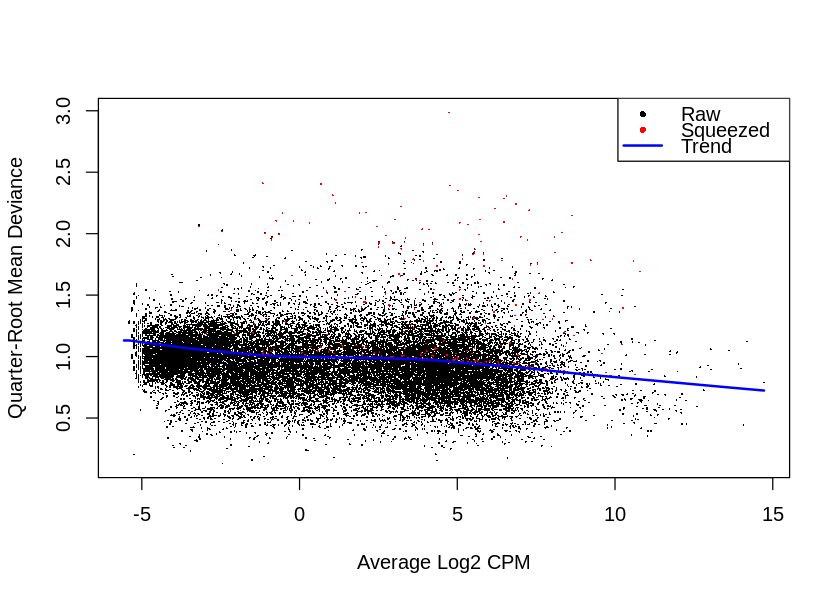

   logFC logCPM    F  PValue de_gene target subclass  label
1 -0.138    6.5 21.2 4.2e-06 GALNT11   DE11   ckd_de CKD DE
2 -0.663    1.3 18.4 1.8e-05   XRCC2   DE11   ckd_de CKD DE
3  0.179    3.5  7.8 5.3e-03   CHPF2   DE11   ckd_de CKD DE
4  0.136    4.1  6.5 1.1e-02    CDK5   DE11   ckd_de CKD DE
5  0.106    4.4  4.8 2.9e-02  SLC4A2   DE11   ckd_de CKD DE
6  0.052    7.0  3.4 6.4e-02   KMT2C   DE11   ckd_de CKD DE
-------------------------------------------------------

DE12 DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   868 
DE12-2a   1613 
DE12-1b   1845 
DE12-2b   2106 
Guide+ = 2106 ; Guide- = 25036 

donor0 donor1 donor2 donor3 
   485    451    647    523 


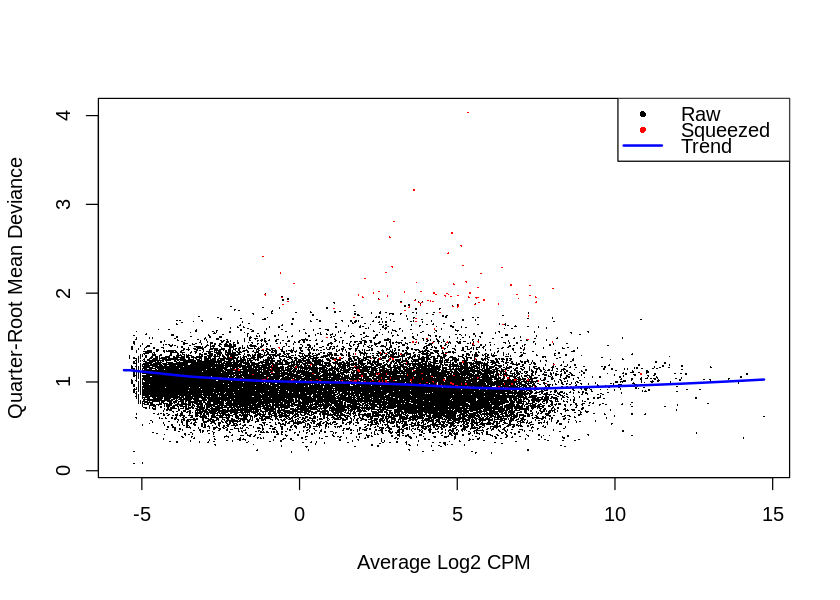

  logFC logCPM    F  PValue de_gene target subclass  label
1 -0.29   5.19 49.1 2.4e-12 SHROOM3   DE12   ckd_de CKD DE
2 -3.19  -0.53 47.5 5.4e-12  CXCL10   DE12   ckd_de CKD DE
3 -0.28   4.13 24.3 8.4e-07   CCNG2   DE12   ckd_de CKD DE
4 -2.53  -1.48 18.3 1.8e-05  CXCL11   DE12   ckd_de CKD DE
5  0.21   4.05 14.3 1.5e-04   THAP6   DE12   ckd_de CKD DE
6 -0.17   3.48  6.4 1.1e-02    NAAA   DE12   ckd_de CKD DE
-------------------------------------------------------

DE13 DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   797 
DE13-2a   1426 
DE13-1b   1446 
DE13-2b   1639 
Guide+ = 1639 ; Guide- = 25503 

donor0 donor1 donor2 donor3 
   371    324    509    435 


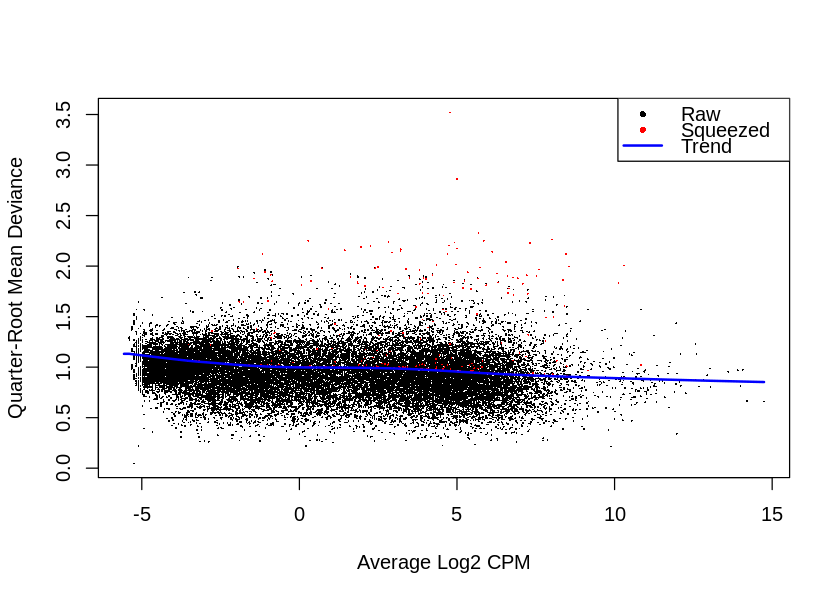

   logFC logCPM    F  PValue   de_gene target subclass  label
1 -0.389   4.28 41.9 9.8e-11     CENPW   DE13   ckd_de CKD DE
2 -0.097   5.63  6.2 1.3e-02     HDDC2   DE13   ckd_de CKD DE
3  0.134   4.14  5.3 2.2e-02     HINT3   DE13   ckd_de CKD DE
4 -0.747  -0.55  4.7 3.0e-02 NCOA7-AS1   DE13   ckd_de CKD DE
5  0.071   6.28  4.5 3.4e-02    TRMT11   DE13   ckd_de CKD DE
6 -0.060   6.57  3.6 5.9e-02   TPD52L1   DE13   ckd_de CKD DE
-------------------------------------------------------

DE14 DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   941 
DE14-2a   1743 
DE14-1b   2023 
DE14-2b   2232 
Guide+ = 2232 ; Guide- = 24910 

donor0 donor1 donor2 donor3 
   529    468    699    536 


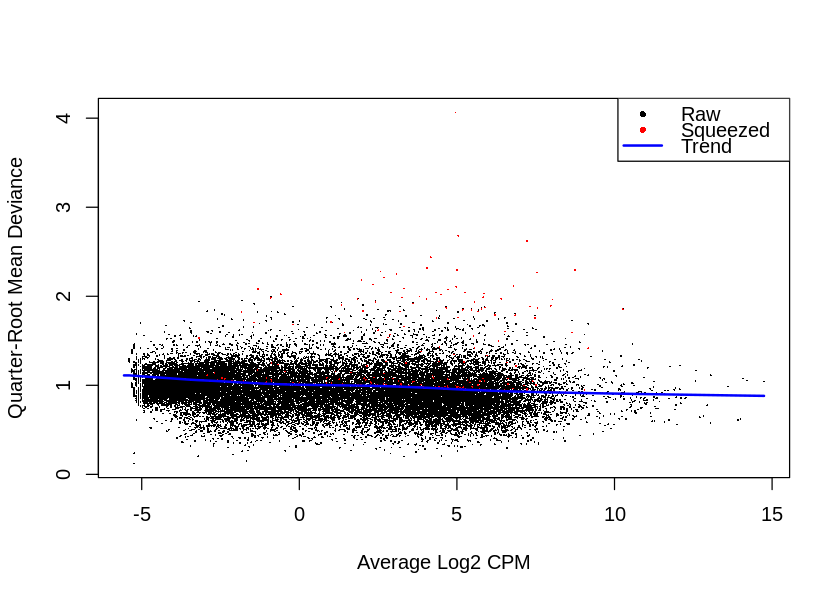

   logFC logCPM     F  PValue de_gene target subclass  label
1 -0.332    4.3 41.28 1.3e-10   FKBP9   DE14   ckd_de CKD DE
2 -0.352    3.5 25.90 3.6e-07   PDE1C   DE14   ckd_de CKD DE
3  0.422    0.7  6.98 8.3e-03   BMPER   DE14   ckd_de CKD DE
4  0.052    5.8  2.42 1.2e-01    BBS9   DE14   ckd_de CKD DE
5 -0.030    6.3  0.93 3.3e-01    LSM5   DE14   ckd_de CKD DE
6  0.042    4.2  0.66 4.2e-01     RP9   DE14   ckd_de CKD DE
-------------------------------------------------------

DE15 DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   844 
DE15-2a   1796 
DE15-1b   2015 
DE15-2b   2324 
Guide+ = 2324 ; Guide- = 24818 

donor0 donor1 donor2 donor3 
   553    475    711    585 


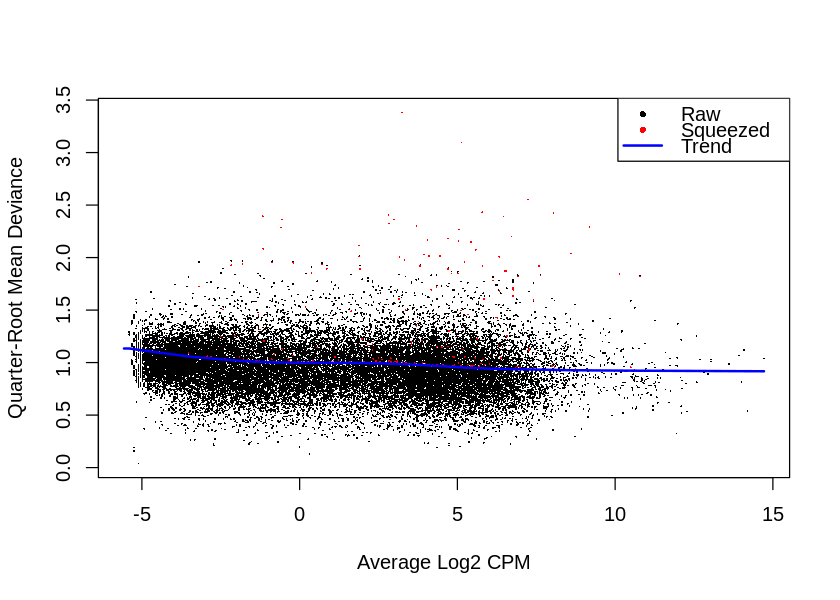

   logFC logCPM     F   PValue   de_gene target subclass  label
1 -0.468    8.3 520.8 5.2e-115     RBPMS   DE15   ckd_de CKD DE
2  0.064    6.6   6.1  1.4e-02    PPP2CB   DE15   ckd_de CKD DE
3  0.137    2.7   2.8  9.4e-02 RBPMS-AS1   DE15   ckd_de CKD DE
4  0.053    5.5   2.5  1.1e-01  LEPROTL1   DE15   ckd_de CKD DE
5  0.477   -1.5   2.0  1.6e-01 LINC00589   DE15   ckd_de CKD DE
6 -4.108   -4.6   1.9  1.7e-01 LINC02209   DE15   ckd_de CKD DE
-------------------------------------------------------

DE16 DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   741 
DE16-2a   741 
DE16-1b   1049 
DE16-2b   1872 
Guide+ = 1872 ; Guide- = 25270 

donor0 donor1 donor2 donor3 
   422    398    587    465 


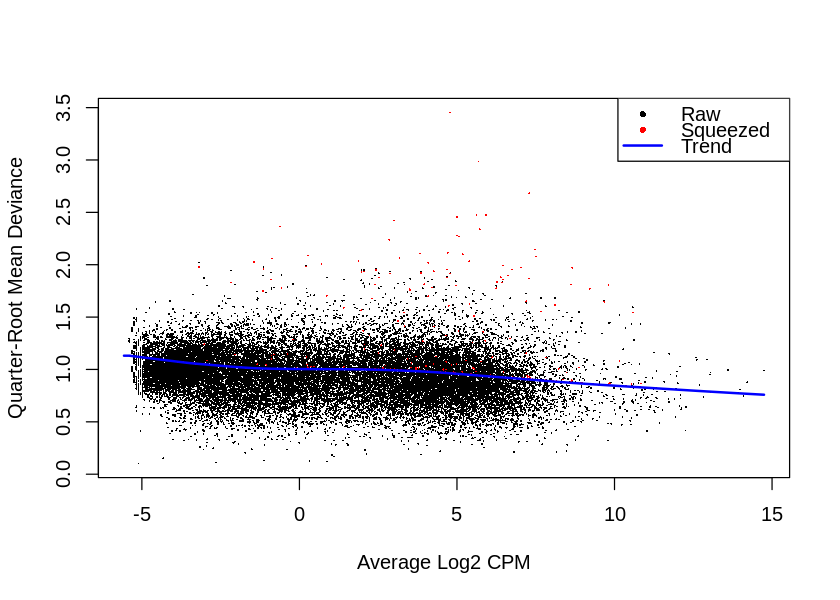

  logFC logCPM    F  PValue   de_gene target subclass  label
1 -0.29    6.5 65.1 7.1e-16     PKHD1   DE16   ckd_de CKD DE
2 -0.31    4.3 29.8 4.9e-08      MCM3   DE16   ckd_de CKD DE
3 -0.29    3.8 18.7 1.5e-05    TFAP2B   DE16   ckd_de CKD DE
4 -0.13    4.5  6.5 1.1e-02     EFHC1   DE16   ckd_de CKD DE
5  3.92   -5.5  3.4 6.6e-02     IL17F   DE16   ckd_de CKD DE
6  0.12    3.1  2.3 1.3e-01 TRAM2-AS1   DE16   ckd_de CKD DE
-------------------------------------------------------

DE17 DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   815 
DE17-2a   1556 
DE17-1b   1784 
DE17-2b   2036 
Guide+ = 2036 ; Guide- = 25106 

donor0 donor1 donor2 donor3 
   445    426    628    537 


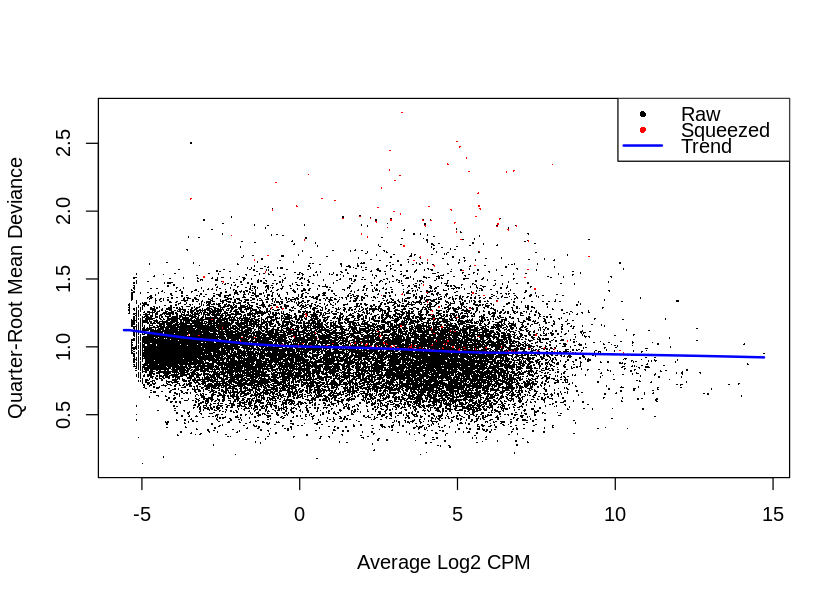

   logFC logCPM    F  PValue  de_gene target subclass  label
1 -0.655    1.3 17.2 3.4e-05    XRCC2   DE17   ckd_de CKD DE
2 -0.101    6.5 11.0 8.9e-04  GALNT11   DE17   ckd_de CKD DE
3 -0.127    4.8  7.8 5.2e-03 TMEM176A   DE17   ckd_de CKD DE
4  0.074    7.2  7.4 6.5e-03     RHEB   DE17   ckd_de CKD DE
5 -0.105    5.1  6.5 1.1e-02 TMEM176B   DE17   ckd_de CKD DE
6  0.142    3.9  6.0 1.4e-02    AGAP3   DE17   ckd_de CKD DE
-------------------------------------------------------



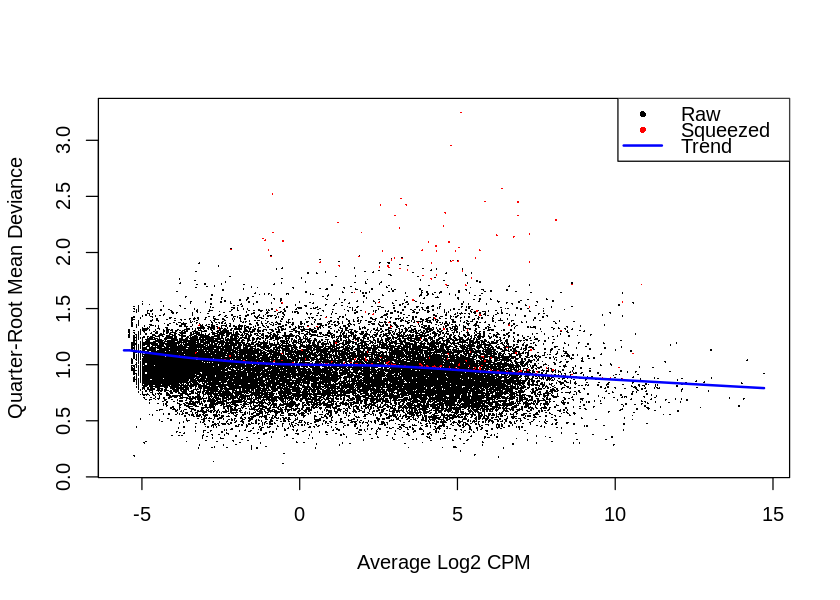

In [215]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
#df_targets = unique(filter(df_guide, alias=='PLIN3'))
df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01
n_tests = 0

for(i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        is_de = FALSE
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
    #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'target_positive')$donor) )


    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] = 1
    cluster_list[cluster_list == "target_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Add target+/- counts to df_cell_counts
    if(!is_de) {
        df_dummy = as.data.frame(y$counts[target,])
        colnames(df_dummy) = "count"
        df_dummy$target <- target
        df_dummy$label = rownames(df_dummy)
        df_dummy$subclass = target_subclass
        df_samples = y$samples
        df_dummy = merge(df_dummy, df_samples, by = 0)
        df_cell_counts = rbind(df_cell_counts, df_dummy)
    }

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    table(keep.samples)
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
    table(keep.genes)
    y <- normLibSizes(y)

    # Create design matrix
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
    diag(contr) <- 1
    contr[1,] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))
    
    # Estimate dispersion
    y <- estimateDisp(y, design, robust=TRUE)
    y$common.dispersion

    # Fit
    fit <- glmQLFit(y, design, robust=TRUE)
    qlf <- glmQLFTest(fit, contrast=contr[,1])
    options(repr.plot.width = 7, repr.plot.height = 5)
    plotQLDisp(fit)
    n_tests = n_tests + length(neighbors)

    if(de_testing == "NEIGHBORHOOD") {
        markers <- qlf$table[neighbors, ] %>% arrange(PValue)
    } else { 
        # Test all genes
        markers <- qlf$table %>% arrange(PValue)
    }
    
    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(head(markers))
    cat("-------------------------------------------------------\n\n")
}


### Correct p-values by total number of comparisons

In [216]:
#n_tests = length(flatten(neighbors_list)) * length(df_targets)
print(n_tests)
df_neighbor_de$p_val_adj_mine =  p.adjust(
    p = df_neighbor_de$PValue,
    method = "bonferroni",
    n = n_tests
)

[1] 725


In [217]:
head(df_neighbor_de)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,1.9e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,1.8e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,1.3e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,1.1e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,1.1e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,9.0e-02


In [218]:
df_cell_counts_backup = df_cell_counts

In [219]:
head(df_cell_counts)

,Row.names,count,target,label,subclass,group,lib.size,norm.factors,sample,cluster
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,donor0_cluster0,388,ANPEP,donor0_cluster0,tss,1,6.9e+06,1,donor0,0
2,donor0_cluster1,24813,ANPEP,donor0_cluster1,tss,1,1.6e+08,1,donor0,1
3,donor1_cluster0,533,ANPEP,donor1_cluster0,tss,1,7.9e+06,1,donor1,0
4,donor1_cluster1,25027,ANPEP,donor1_cluster1,tss,1,1.7e+08,1,donor1,1
5,donor2_cluster0,835,ANPEP,donor2_cluster0,tss,1,1.2e+07,1,donor2,0
6,donor2_cluster1,33783,ANPEP,donor2_cluster1,tss,1,2.2e+08,1,donor2,1


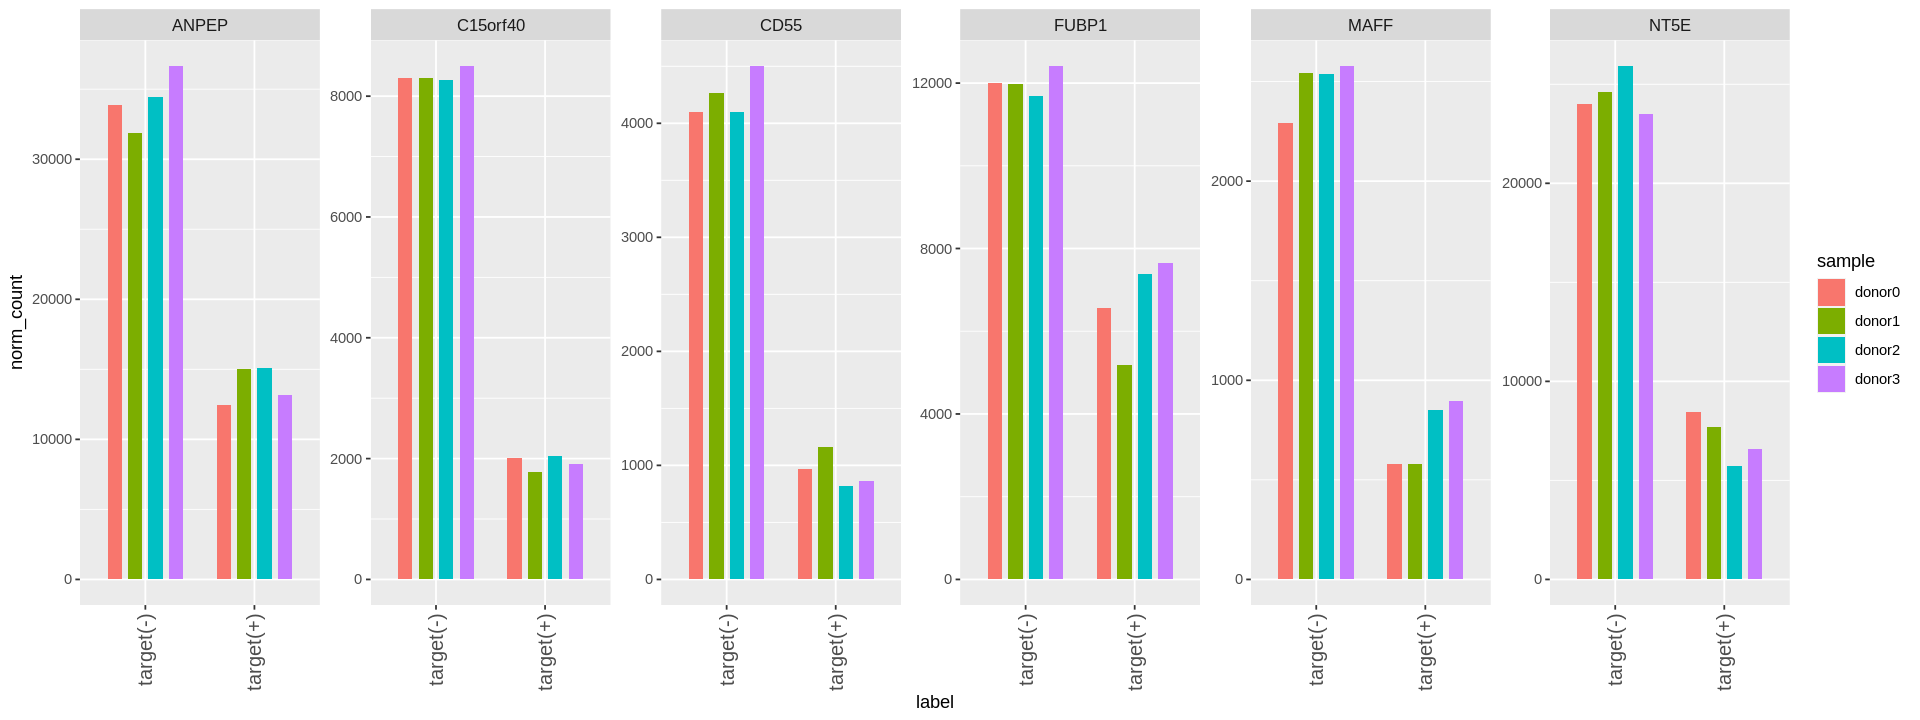

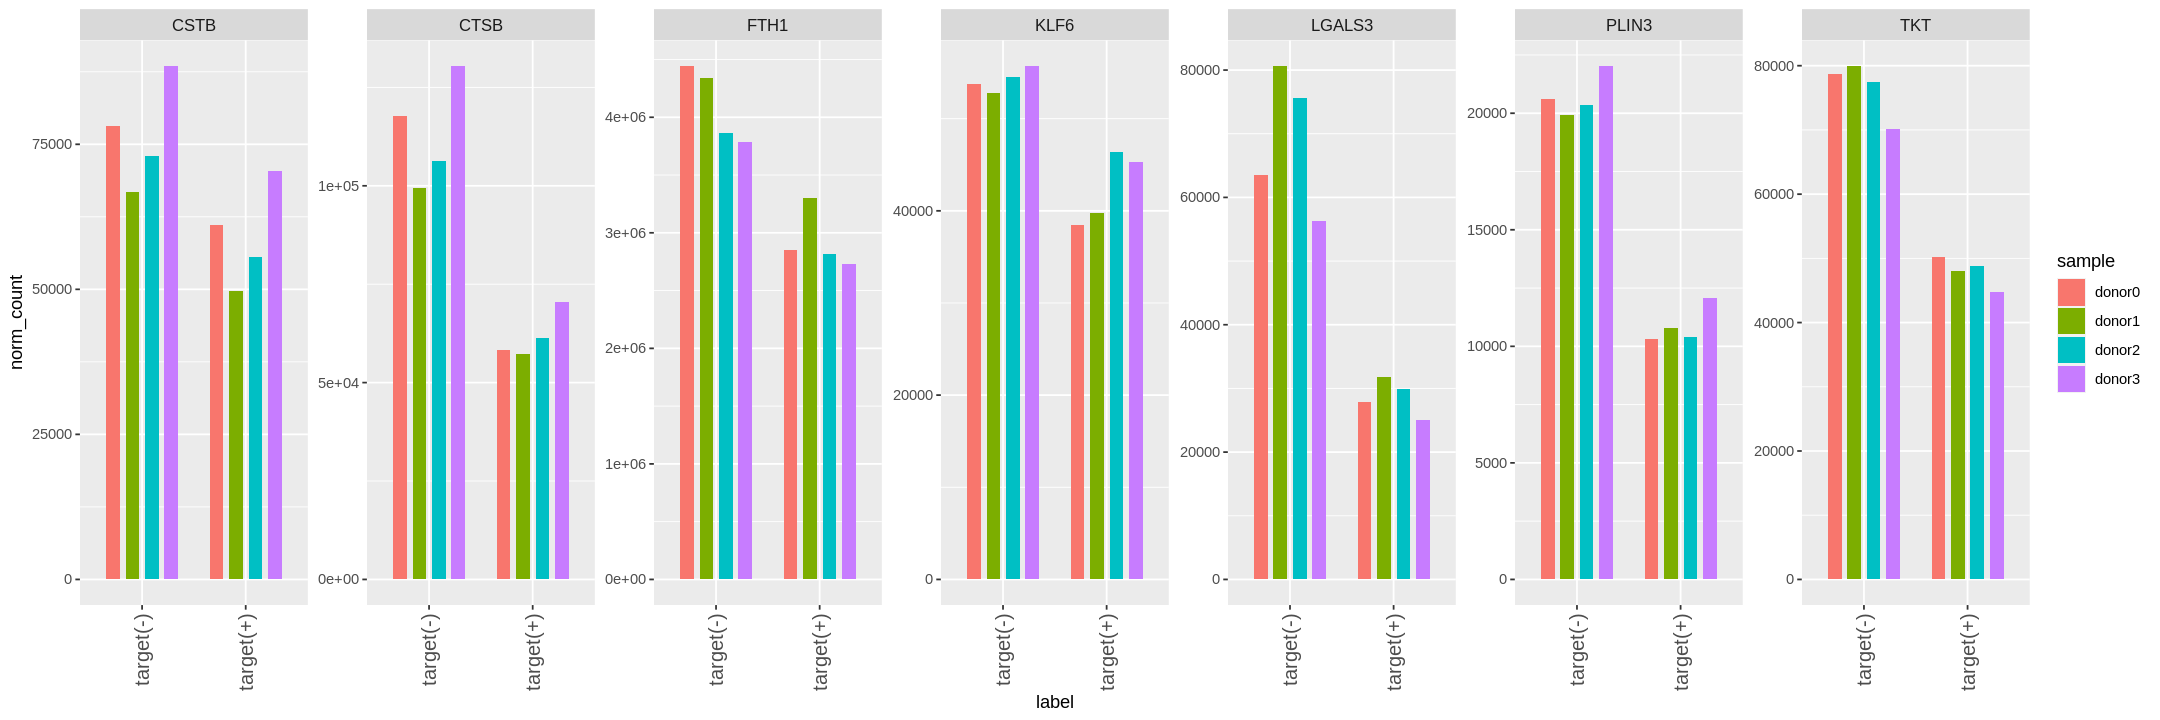

In [220]:
df_cell_counts = df_cell_counts_backup
df_cell_counts$label = str_replace(df_cell_counts$label, "donor._", "")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster0", "target(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "cluster1", "target(-)")

df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

df_cell_counts_tss = df_cell_counts %>% filter(subclass == 'tss')
df_cell_counts_de  = df_cell_counts %>% filter(subclass == 'de_control')

options(repr.plot.width=16, repr.plot.height=6)
ggplot(df_cell_counts_tss, aes(x = label, y = norm_count, fill = sample))+
    geom_bar(position = position_dodge2(padding = 0.3), width = 0.75, stat="identity")  +
    facet_wrap(~ target, scales="free", ncol = 6) +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 

options(repr.plot.width=18, repr.plot.height=6)
ggplot(df_cell_counts_de, aes(x = label, y = norm_count, fill = sample))+
    geom_bar(position = position_dodge2(padding = 0.3), width = 0.75, stat="identity")  +    
    facet_wrap(~ target, scales="free", ncol = 7) +
    theme(
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 12), 
        strip.text = element_text(size=10)
    ) 

#geom_bar(position = position_dodge2(padding = 0.3), stat="identity")  +

In [221]:
head(df_cell_counts)

,Row.names,count,target,label,subclass,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,388,ANPEP,target(+),tss,1,6.9e+06,1,donor0,0,12474
2,donor0_cluster1,24813,ANPEP,target(-),tss,1,1.6e+08,1,donor0,1,33842
3,donor1_cluster0,533,ANPEP,target(+),tss,1,7.9e+06,1,donor1,0,15001
4,donor1_cluster1,25027,ANPEP,target(-),tss,1,1.7e+08,1,donor1,1,31867
5,donor2_cluster0,835,ANPEP,target(+),tss,1,1.2e+07,1,donor2,0,15111
6,donor2_cluster1,33783,ANPEP,target(-),tss,1,2.2e+08,1,donor2,1,34475


In [222]:
head(df_cell_counts_tss)

,Row.names,count,target,label,subclass,group,lib.size,norm.factors,sample,cluster,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1,donor0_cluster0,388,ANPEP,target(+),tss,1,6.9e+06,1,donor0,0,12474
2,donor0_cluster1,24813,ANPEP,target(-),tss,1,1.6e+08,1,donor0,1,33842
3,donor1_cluster0,533,ANPEP,target(+),tss,1,7.9e+06,1,donor1,0,15001
4,donor1_cluster1,25027,ANPEP,target(-),tss,1,1.7e+08,1,donor1,1,31867
5,donor2_cluster0,835,ANPEP,target(+),tss,1,1.2e+07,1,donor2,0,15111
6,donor2_cluster1,33783,ANPEP,target(-),tss,1,2.2e+08,1,donor2,1,34475


## Inpect DE results

Print top high-confidence hits

In [223]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.29,7.9,2409,0.0e+00,LGALS3,LGALS3,de_control,Control DE,0.0e+00
2,-0.90,8.7,1612,8.8e-302,CTSB,CTSB,de_control,Control DE,6.4e-299
3,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,1.9e-204
4,-0.95,6.3,802,9.8e-176,PLIN3,PLIN3,de_control,Control DE,7.1e-173
5,-2.14,4.9,790,3.1e-173,C15orf40,C15orf40,tss,Control TSS,2.3e-170
6,-1.00,6.0,908,9.3e-171,NDRG1,DE6,ckd_de,CKD DE,6.7e-168
7,-1.85,6.4,1291,6.0e-165,NT5E,NT5E,tss,Control TSS,4.4e-162
8,-0.70,8.2,632,3.9e-139,TKT,TKT,de_control,Control DE,2.8e-136
9,-0.47,8.3,521,5.2e-115,RBPMS,DE15,ckd_de,CKD DE,3.8e-112


In [224]:
df_neighbor_de %>% filter(logFC > 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.236,6.49,77.9,1.4e-18,SLC3A2,FTH1,de_control,Control DE,1.0e-15
2,0.145,11.21,45.9,1.2e-11,RPL36,PLIN3,de_control,Control DE,9.0e-09
3,0.184,6.61,43.0,5.5e-11,TNFRSF10B,DE7,ckd_de,CKD DE,4.0e-08
4,0.405,2.34,27.5,1.6e-07,VWCE,FTH1,de_control,Control DE,1.2e-04
5,0.279,3.42,26.3,2.9e-07,SNHG1,FTH1,de_control,Control DE,2.1e-04
6,0.130,7.69,24.4,7.8e-07,NRIP1,DE1,ckd_de,CKD DE,5.7e-04
7,0.233,5.38,23.1,1.5e-06,AP3S2,ANPEP,tss,Control TSS,1.1e-03
8,0.173,4.50,19.1,1.3e-05,WDR74,FTH1,de_control,Control DE,9.2e-03
9,0.208,5.43,18.8,1.5e-05,MFGE8,ANPEP,tss,Control TSS,1.1e-02


### Check the TSS

In [225]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(40)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.91,1122.3,2.6e-207,ANPEP,ANPEP,tss,Control TSS,1.9e-204
2,-2.14,4.94,790.1,3.1e-173,C15orf40,C15orf40,tss,Control TSS,2.3e-170
3,-1.85,6.37,1290.8,6.0e-165,NT5E,NT5E,tss,Control TSS,4.4e-162
4,-2.20,4.06,432.1,8.8e-96,CD55,CD55,tss,Control TSS,6.4e-93
5,-0.86,5.59,246.5,5.1e-55,FUBP1,FUBP1,tss,Control TSS,3.7e-52
6,-1.82,3.37,167.0,3.5e-38,MAFF,MAFF,tss,Control TSS,2.5e-35
7,-0.33,6.66,76.3,2.5e-18,IDH2,ANPEP,tss,Control TSS,1.8e-15
8,-0.19,10.47,57.9,2.7e-14,LGALS1,MAFF,tss,Control TSS,2.0e-11
9,-0.20,6.72,27.3,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,1.3e-04


In [226]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC > 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.233,5.4,23.1,1.5e-06,AP3S2,ANPEP,tss,Control TSS,0.0011
2,0.208,5.4,18.8,1.5e-05,MFGE8,ANPEP,tss,Control TSS,0.0108
3,0.149,6.3,14.4,1.5e-04,NGRN,ANPEP,tss,Control TSS,0.1062
4,1.078,-1.1,8.8,2.9e-03,IDH2-DT,ANPEP,tss,Control TSS,1.0000
5,0.308,3.0,8.5,3.6e-03,DNAJB4,FUBP1,tss,Control TSS,1.0000
6,0.262,3.7,8.5,3.6e-03,MICALL1,MAFF,tss,Control TSS,1.0000
7,0.427,1.6,6.8,9.2e-03,CPEB1,C15orf40,tss,Control TSS,1.0000
8,0.159,4.8,5.7,1.7e-02,JOSD1,MAFF,tss,Control TSS,1.0000
9,0.180,3.4,4.2,4.1e-02,MESP1,ANPEP,tss,Control TSS,1.0000


In [227]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.00,6.00,908,9.3e-171,NDRG1,DE6,ckd_de,CKD DE,6.7e-168
2,-0.47,8.29,521,5.2e-115,RBPMS,DE15,ckd_de,CKD DE,3.8e-112
3,-0.83,4.78,319,1.4e-58,CCNB1,DE4,ckd_de,CKD DE,1.0e-55
4,-0.56,4.92,163,2.5e-37,STC1,DE7,ckd_de,CKD DE,1.8e-34
5,-0.34,5.55,91,1.3e-21,LOXL2,DE7,ckd_de,CKD DE,9.2e-19
6,-0.29,6.49,65,7.1e-16,PKHD1,DE16,ckd_de,CKD DE,5.1e-13
7,-0.46,3.68,52,1.1e-12,CHST9,DE5,ckd_de,CKD DE,7.7e-10
8,-0.18,7.93,50,1.8e-12,PDIA6,DE10,ckd_de,CKD DE,1.3e-09
9,-0.29,5.19,49,2.4e-12,SHROOM3,DE12,ckd_de,CKD DE,1.8e-09


In [228]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
-0.52,14.0,834,2.5e-93,FTH1,FTH1,de_control,Control DE,1.8e-90
-0.41,4.7,109,1.6e-25,FADS2,FTH1,de_control,Control DE,1.2e-22
-0.21,8.3,85,3.3e-20,AHNAK,FTH1,de_control,Control DE,2.4e-17
-0.52,3.5,80,4.6e-19,BEST1,FTH1,de_control,Control DE,3.4e-16
0.24,6.5,78,1.4e-18,SLC3A2,FTH1,de_control,Control DE,1.0e-15
-0.25,6.0,73,1.4e-17,ASRGL1,FTH1,de_control,Control DE,1.0e-14
-0.21,5.9,48,3.5e-12,FADS1,FTH1,de_control,Control DE,2.5e-09
-0.95,6.3,802,9.8e-176,PLIN3,PLIN3,de_control,Control DE,7.1e-173
-0.85,2.3,52,5.7e-13,UHRF1,PLIN3,de_control,Control DE,4.1e-10


In [229]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
492,-0.998,6.002,907.780,9.3e-171,NDRG1,DE6,ckd_de,CKD DE,6.7e-168
493,0.059,6.145,3.863,4.9e-02,PHF20L1,DE6,ckd_de,CKD DE,1.0e+00
494,0.142,2.531,3.039,8.1e-02,TG,DE6,ckd_de,CKD DE,1.0e+00
495,0.391,-0.623,2.872,9.0e-02,TMEM71,DE6,ckd_de,CKD DE,1.0e+00
496,0.571,-2.138,2.157,1.4e-01,HPYR1,DE6,ckd_de,CKD DE,1.0e+00
497,0.031,6.772,1.280,2.6e-01,ST3GAL1,DE6,ckd_de,CKD DE,1.0e+00
498,0.208,-0.098,1.116,2.9e-01,SLA,DE6,ckd_de,CKD DE,1.0e+00
499,0.019,4.444,0.175,6.8e-01,KCNQ3,DE6,ckd_de,CKD DE,1.0e+00
500,0.054,-0.039,0.077,7.8e-01,CCN4,DE6,ckd_de,CKD DE,1.0e+00


,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
665,-0.468,8.29,520.808,5.2e-115,RBPMS,DE15,ckd_de,CKD DE,3.8e-112
666,0.064,6.63,6.096,1.4e-02,PPP2CB,DE15,ckd_de,CKD DE,1.0e+00
667,0.137,2.72,2.798,9.4e-02,RBPMS-AS1,DE15,ckd_de,CKD DE,1.0e+00
668,0.053,5.53,2.529,1.1e-01,LEPROTL1,DE15,ckd_de,CKD DE,1.0e+00
669,0.477,-1.52,1.975,1.6e-01,LINC00589,DE15,ckd_de,CKD DE,1.0e+00
670,-4.108,-4.61,1.896,1.7e-01,LINC02209,DE15,ckd_de,CKD DE,1.0e+00
671,-0.049,4.94,1.463,2.3e-01,WRN,DE15,ckd_de,CKD DE,1.0e+00
672,0.031,6.41,1.303,2.5e-01,SARAF,DE15,ckd_de,CKD DE,1.0e+00
673,-0.040,5.00,1.023,3.1e-01,DCTN6,DE15,ckd_de,CKD DE,1.0e+00


## Volcano Plot

In [230]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 31 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


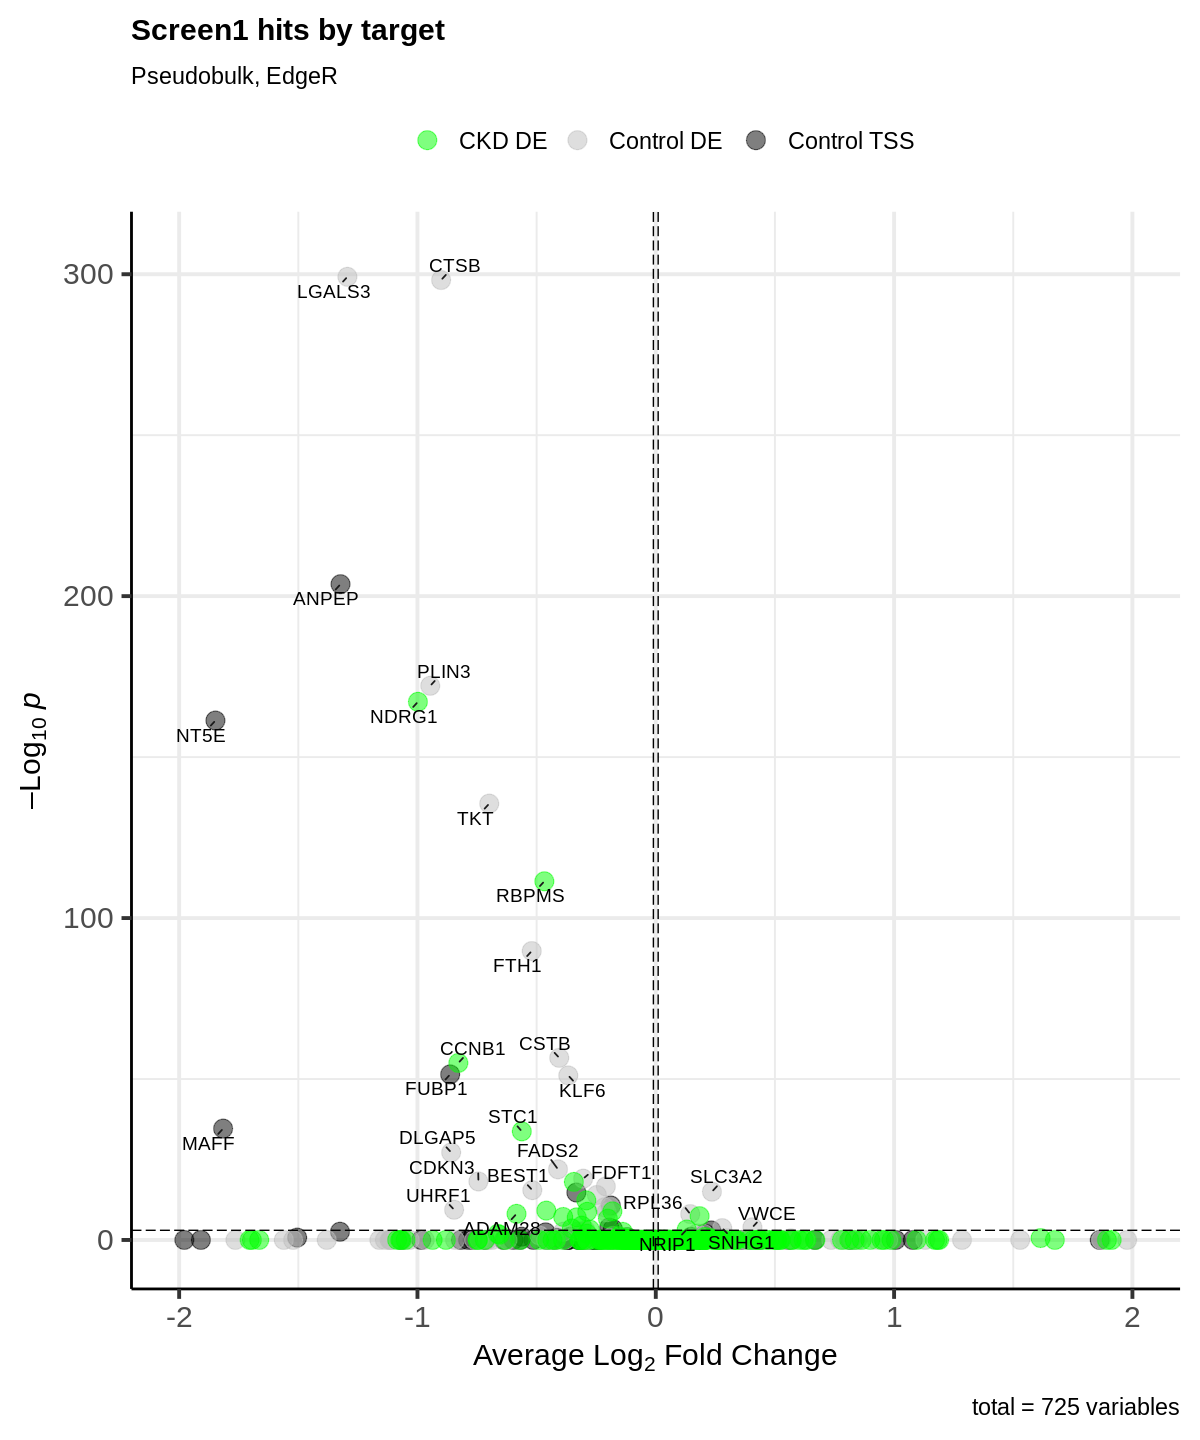

In [231]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, "hits by target"),
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-04,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 1 rows containing missing values (`geom_hline()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_hline()`)."
Warning message:
"ggrepel: 127 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


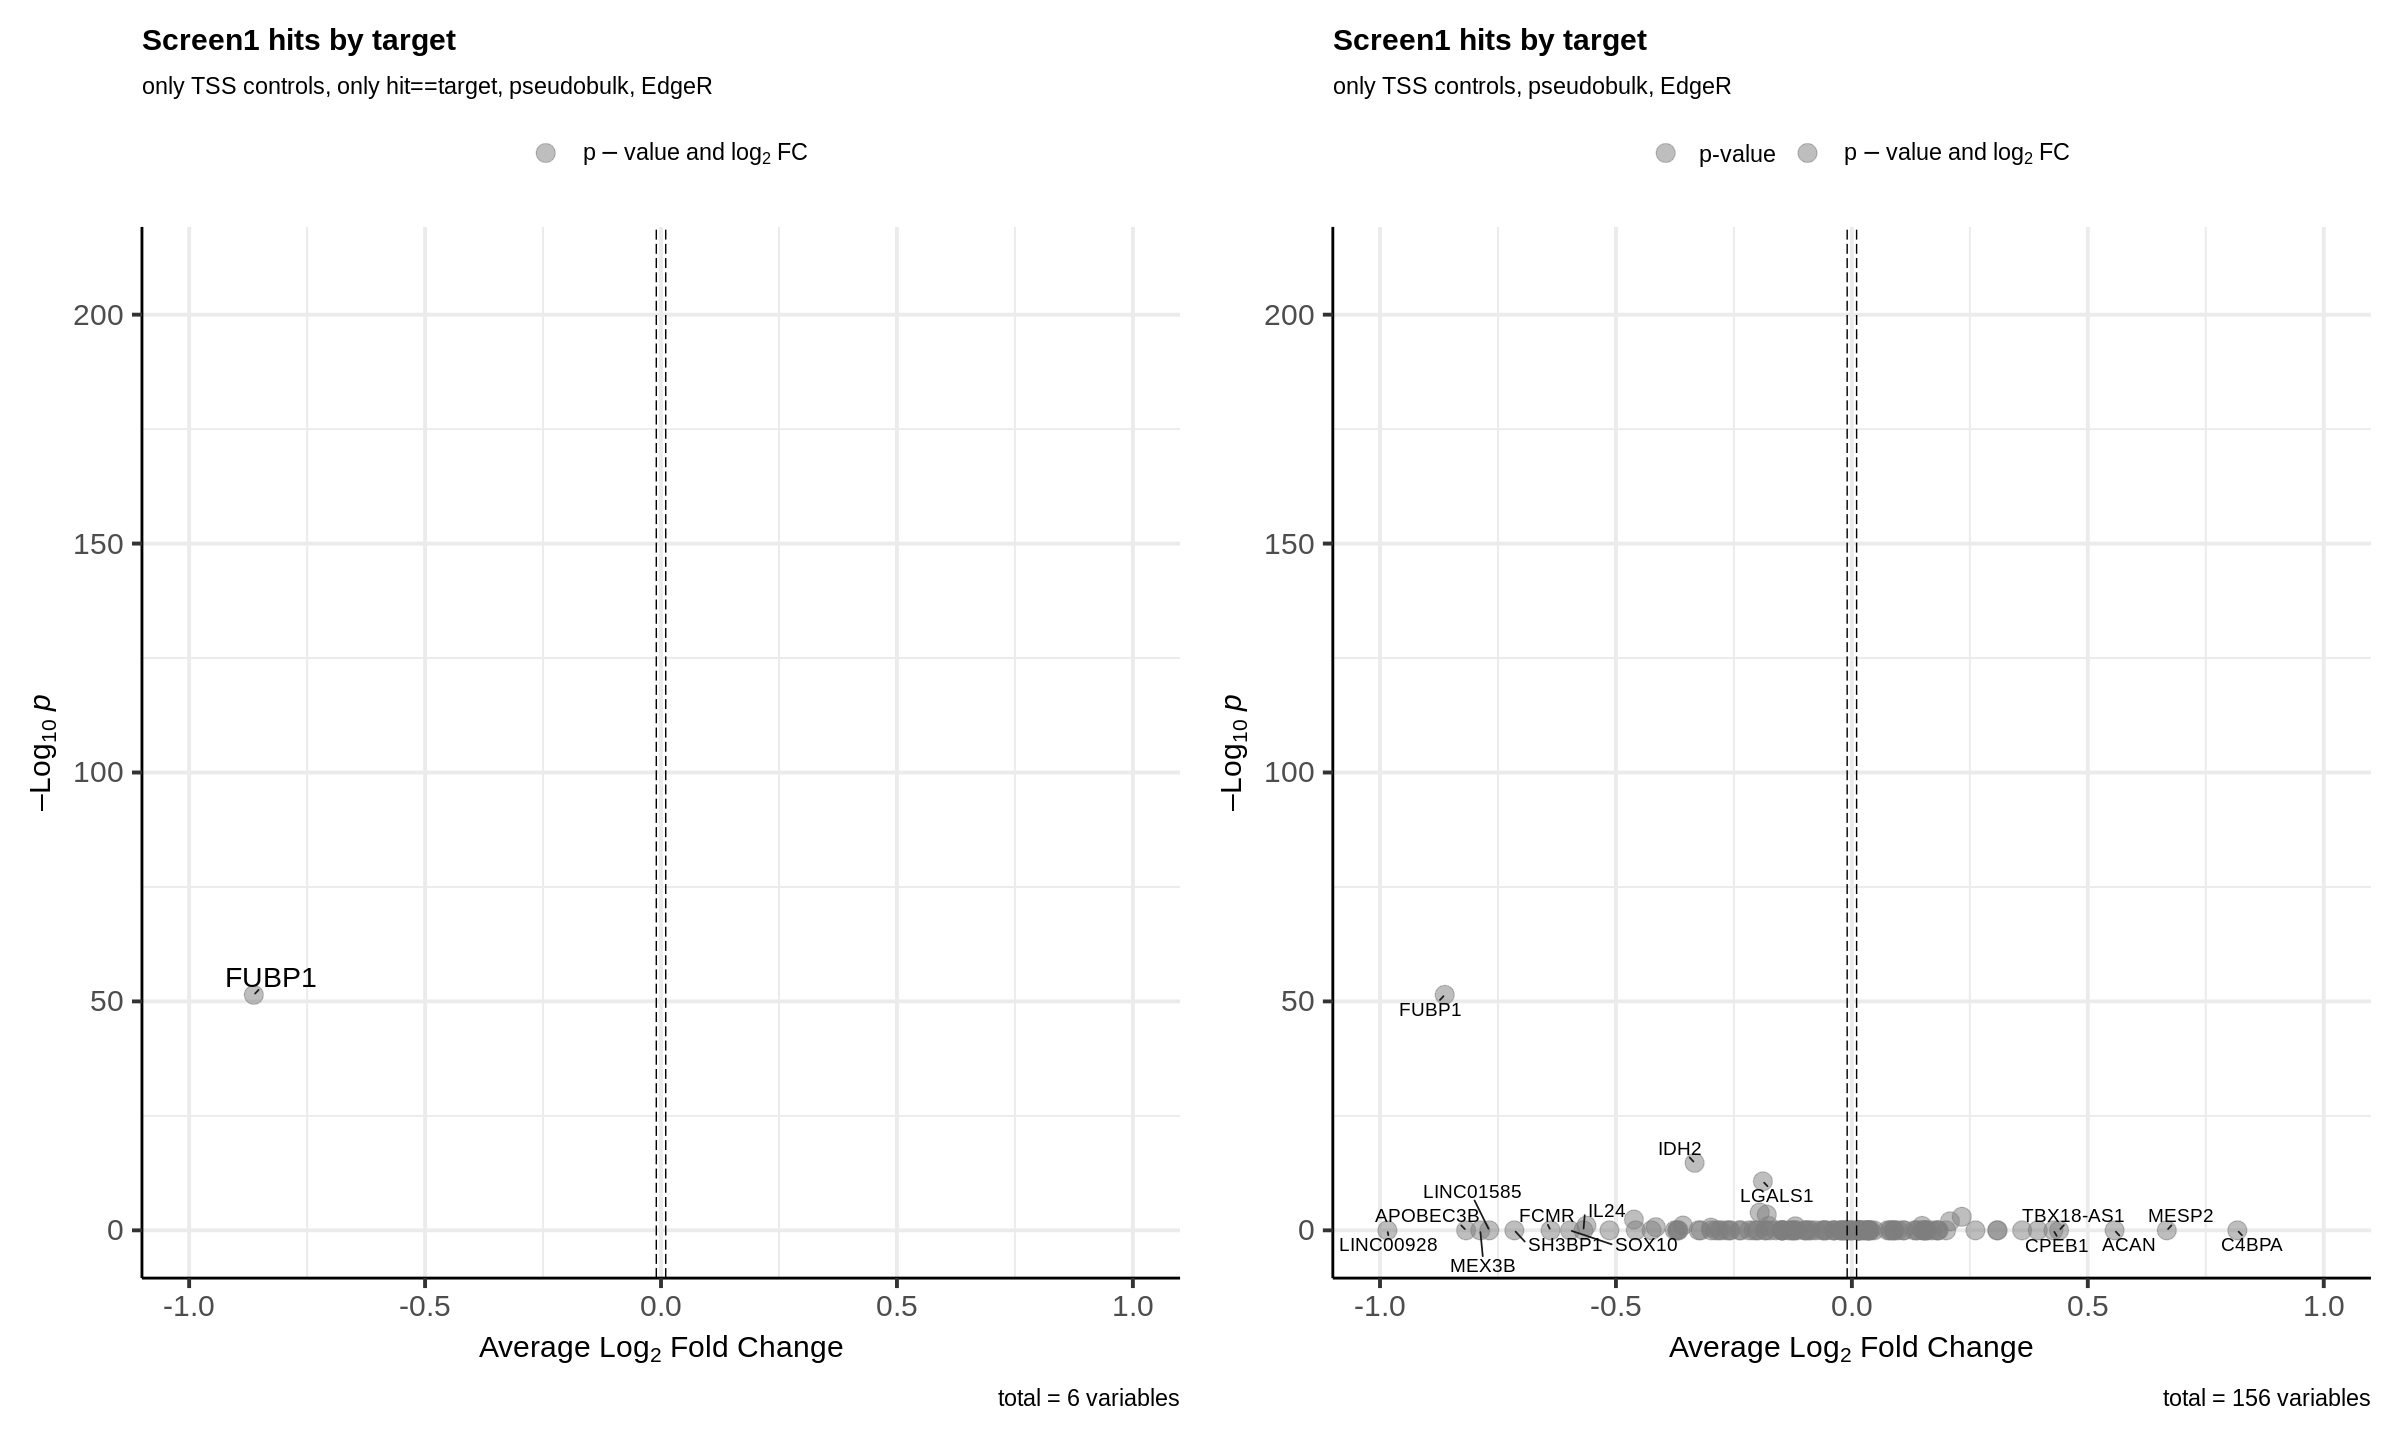

In [232]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-0,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-0,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-1, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [233]:
head(df_neighbor_de_subset)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS,1.9e-204
2,-0.33,6.7,76,2.5e-18,IDH2,ANPEP,tss,Control TSS,1.8e-15
3,-0.20,6.7,27,1.8e-07,SEMA4B,ANPEP,tss,Control TSS,1.3e-04
4,0.23,5.4,23,1.5e-06,AP3S2,ANPEP,tss,Control TSS,1.1e-03
5,0.21,5.4,19,1.5e-05,MFGE8,ANPEP,tss,Control TSS,1.1e-02
6,-0.36,3.5,15,1.2e-04,FANCI,ANPEP,tss,Control TSS,9.0e-02


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


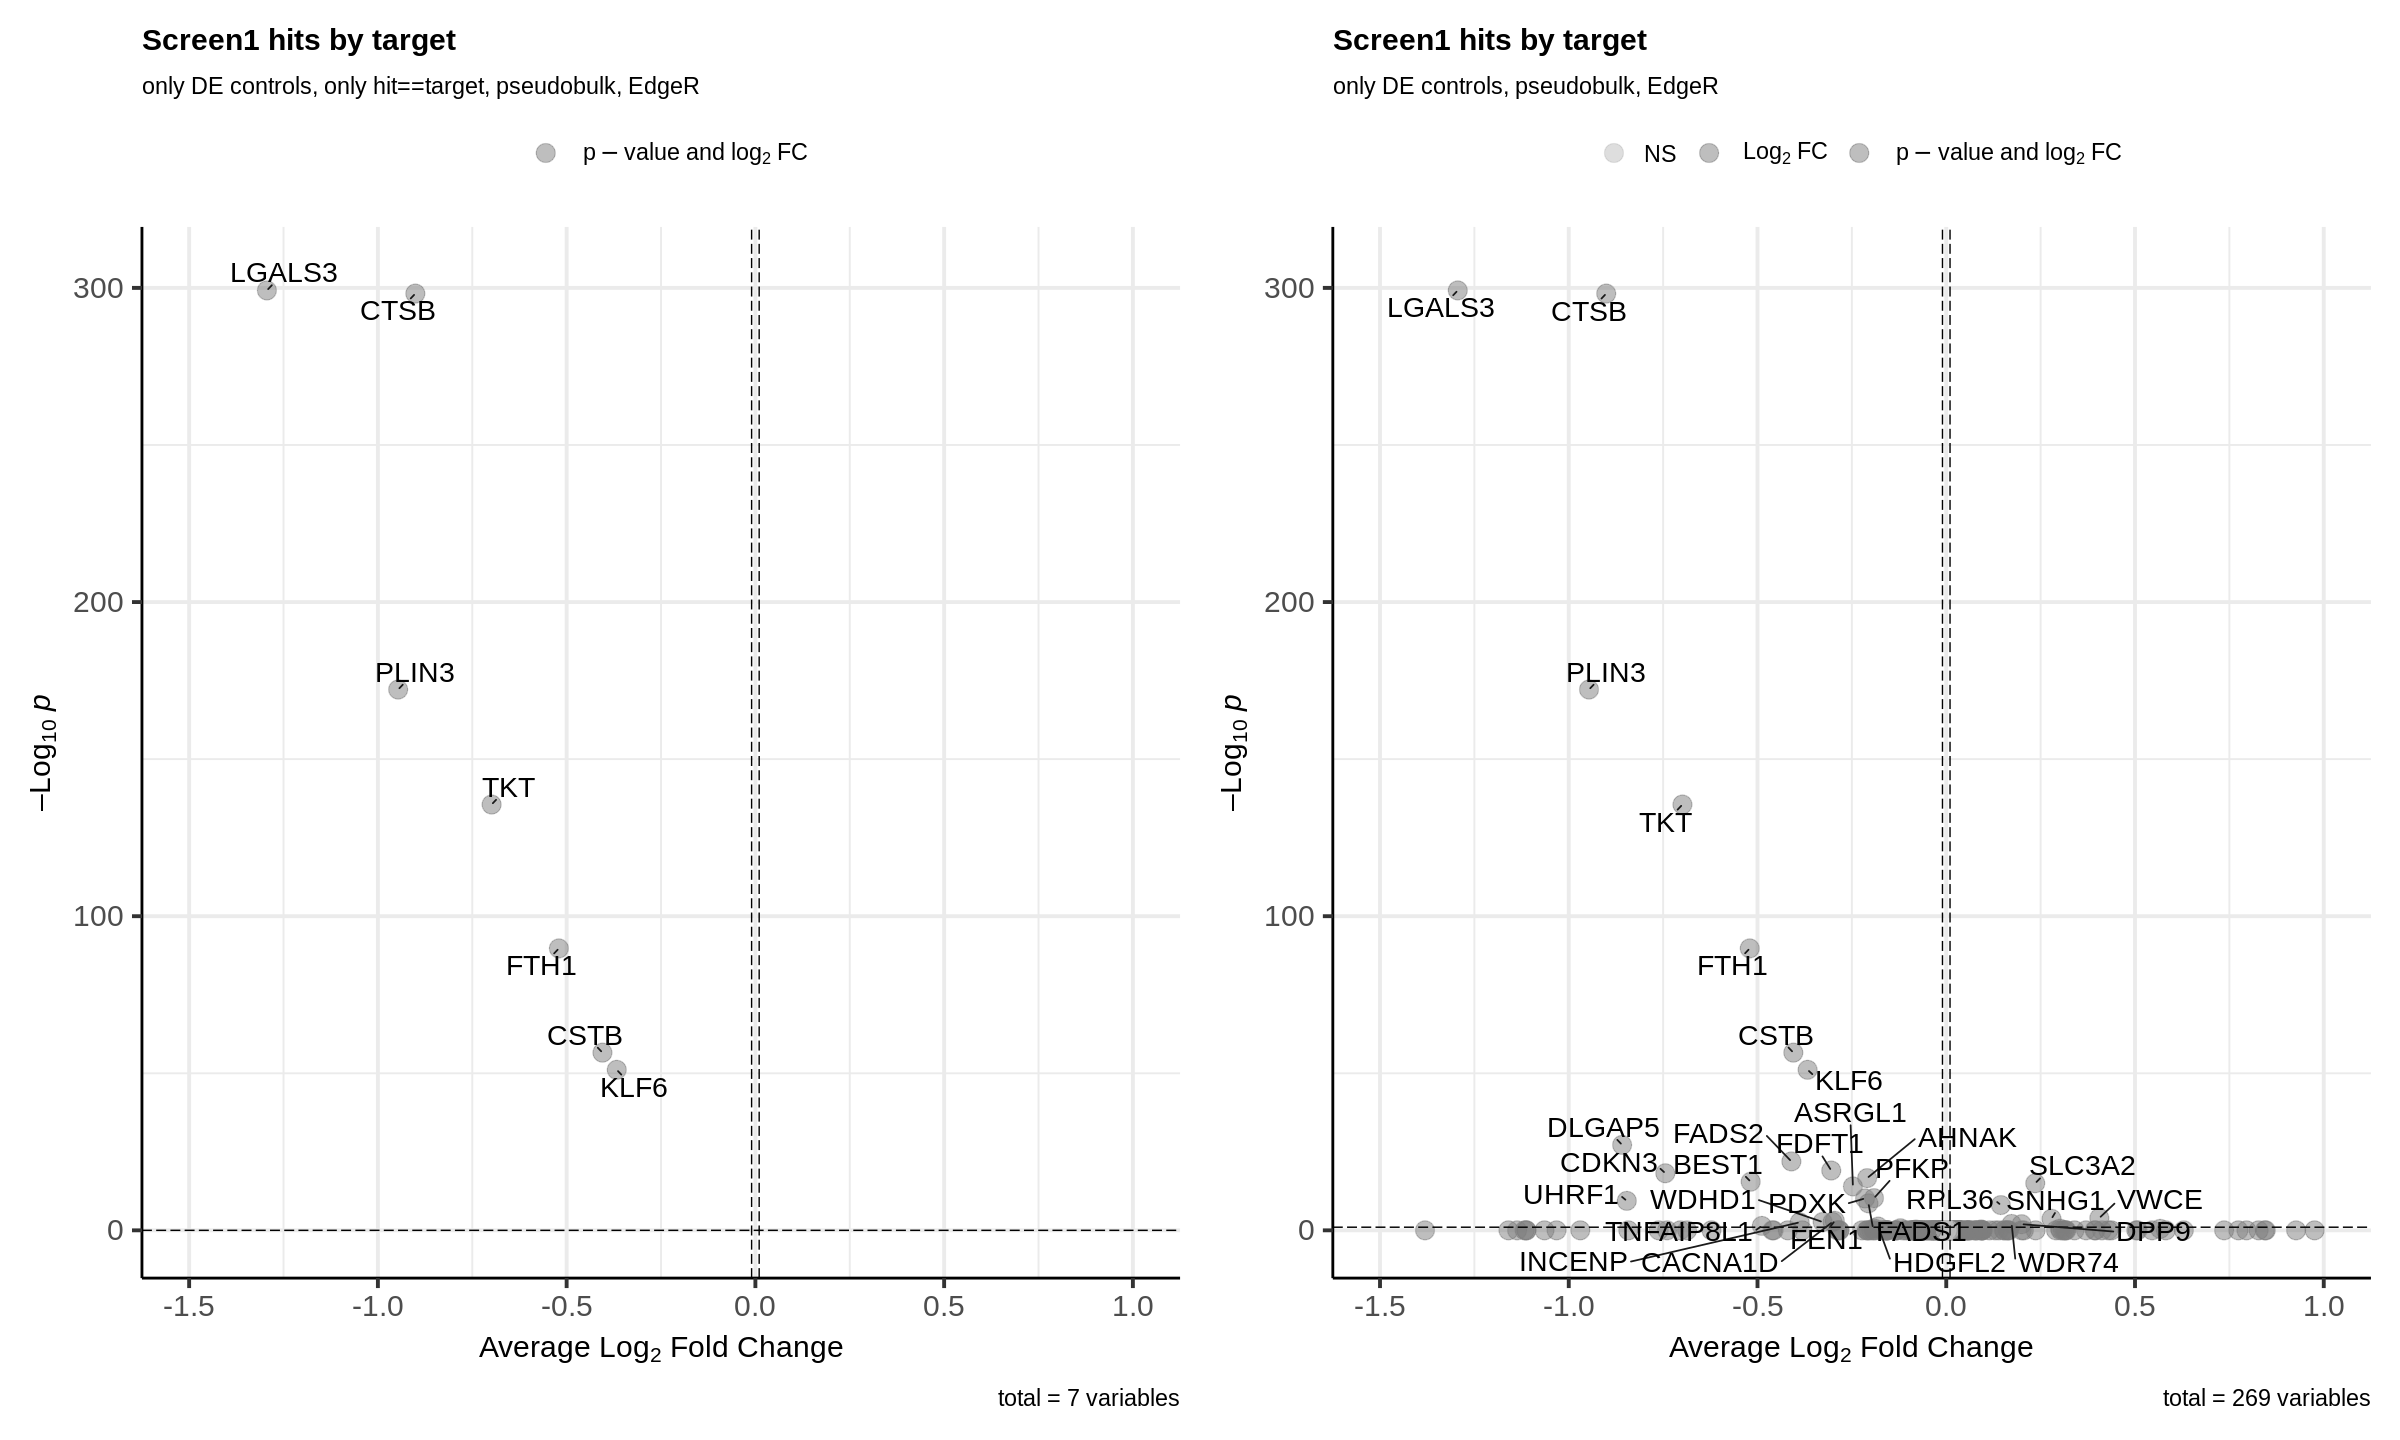

In [234]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-1,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-2,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-1.5, 1) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


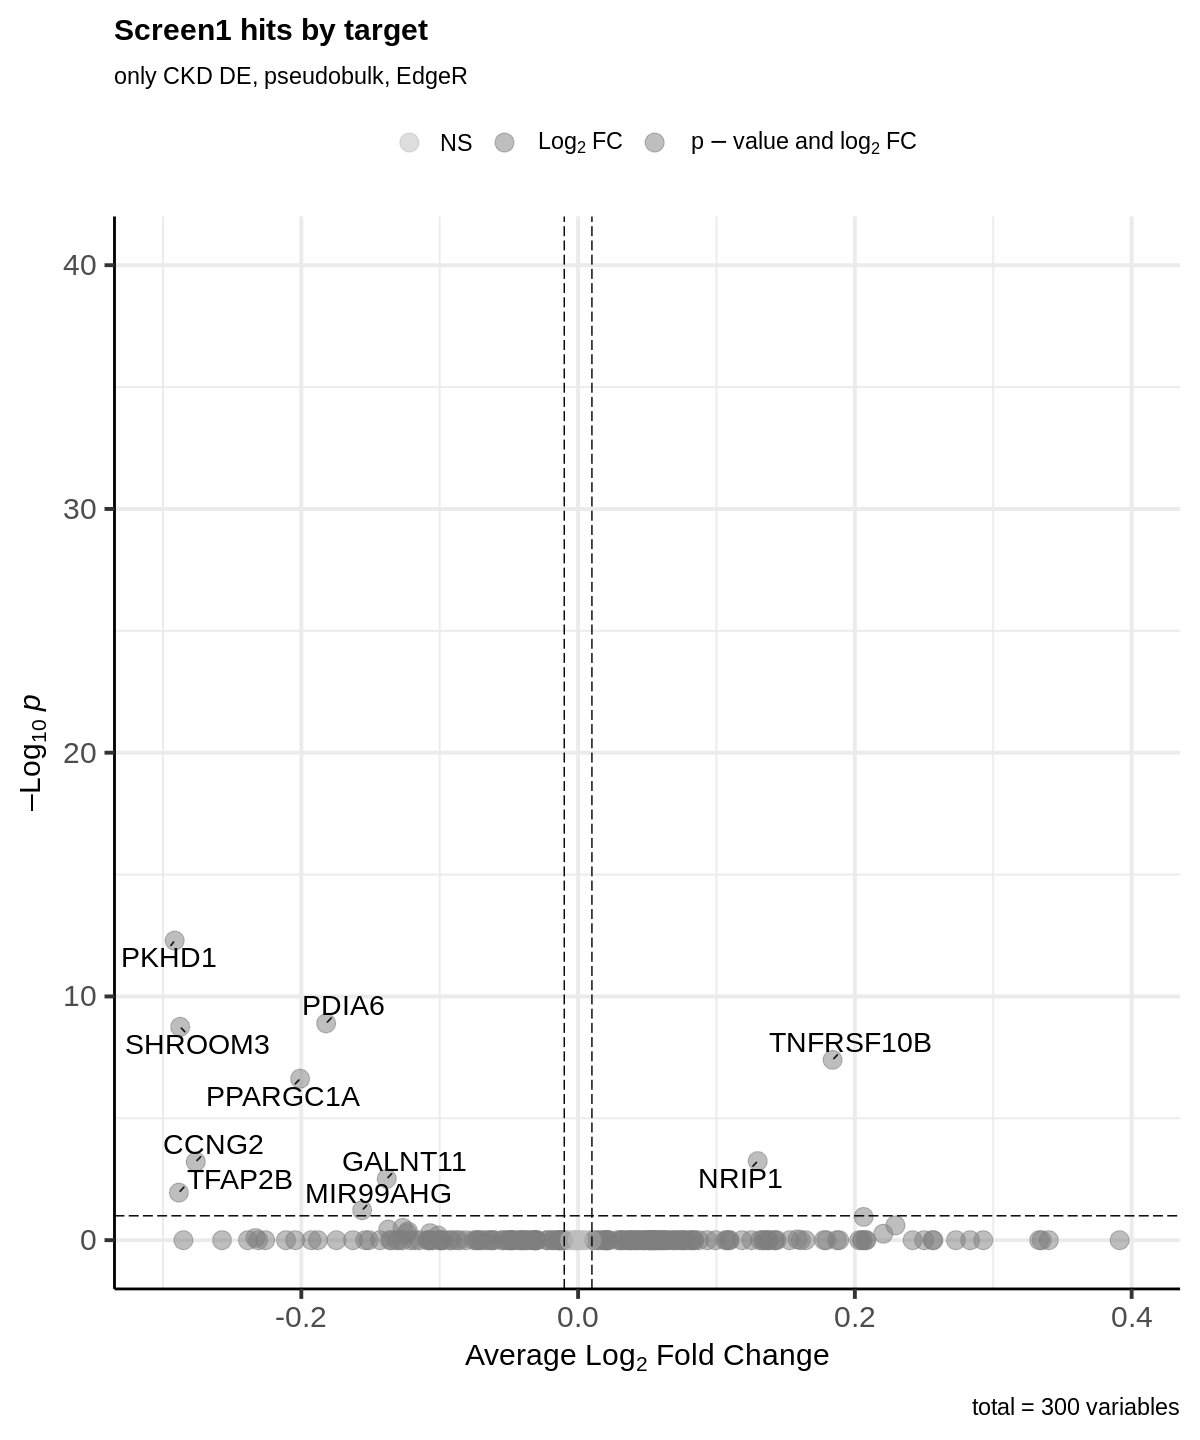

In [235]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y = "p_val_adj_mine",
                title = paste(prj_name, 'hits by target'),
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-2,
                FCcutoff = logfc_threshold,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-0.3, 0.4) +
                ylim(0, 40) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Inspect further

In [242]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC < 0) %>% filter(PValue < 5 * 10e-2) %>% arrange(PValue) %>% head(30) %>% write.csv(file="Screen1_hits.csv")

In [241]:
dir()

[1] "00_QC.R.ipynb"                                                
 [2] "01_Integrate.R.ipynb"                                         
 [3] "02_Post-integration_QC_and_viz.ipynb"                         
 [4] "03_Guide_calling_HTOdemux.ipynb"                              
 [5] "03_Guide_calling.ipynb"                                       
 [6] "03b_Post-guide_calling_QC_and_viz.ipynb"                      
 [7] "04_DE_by_donor.ipynb"                                         
 [8] "04_DE_by_plasmid_Pseudobulk_Only_Neigbors_v2_refactored.ipynb"
 [9] "04_DE_by_plasmid_Pseudobulk_Only_Neigbors_v2.ipynb"           
[10] "04_DE_by_plasmid_Pseudobulk_Only_Neigbors.ipynb"              
[11] "04_DE_by_plasmid_v2_single_panel.ipynb"                       
[12] "04_DE_by_plasmid.ipynb"                                       
[13] "04_DE_by_target_Only_Neigbors.ipynb"                          
[14] "04_DE_by_target_Pseudobulk_Only_Neigbors_v2.ipynb"            
[15] "04_DE_by_target_Pseudobulk_Only_Neigbors.ipynb"               
[16] "04_DE_by_target_Test_All_Genes.ipynb"                         
[17] "04_DE_by_target.ipynb"                                        
[18] "04_DE_split_by_guide.ipynb"                                   
[19] "05_Post_DE_QC_and_viz.ipynb"                                  
[20] "06_check_dCas9-sgRNA_count_correl.ipynb"                      
[21] "circular_energies.txt"                                        
[22] "crisprQTL_guide_calling.R"                                    
[23] "DE_report.txt"                                                
[24] "deseq2_tut.ipynb"                                             
[25] "edgeR_tut.ipynb"                                              
[26] "generate_library_csv_for_cellranger.ipynb"                    
[27] "generate_library_csv_for_cellranger.r"                        
[28] "guide_sequences.dummy"                                        
[29] "helper_functions_for_diffex.r"                                
[30] "integration_introduction.Rmd"                                 
[31] "linear_energies.txt"                                          
[32] "mixture.py"                                                   
[33] "RNA_fold.ipynb"                                               
[34] "rna.ps"                                                       
[35] "Screen1_hits"                                                 
[36] "SECONDARY_ANALYSIS.sh"                                        
[37] "seurat_00_Lib2.html"                                          
[38] "test_PG_caller.ipynb"                                         
[39] "untitled.txt"                                                 
[40] "XX_Check_PS_CS alignments.ipynb"                              
[41] "XX_debug_perturbed_counts.ipynb"                              
[42] "XX_geom_hist_bins.ipynb"

In [237]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(logFC > 0) %>% filter(PValue < 1e-2) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label,p_val_adj_mine
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0.184,6.6,43.0,5.5e-11,TNFRSF10B,DE7,ckd_de,CKD DE,4.0e-08
2,0.130,7.7,24.4,7.8e-07,NRIP1,DE1,ckd_de,CKD DE,5.7e-04
3,0.206,4.1,14.3,1.5e-04,THAP6,DE12,ckd_de,CKD DE,1.1e-01
4,0.229,3.4,12.8,3.4e-04,HSPA13,DE3,ckd_de,CKD DE,2.5e-01
5,1.615,-2.0,12.8,3.5e-04,LINC02028,DE2,ckd_de,CKD DE,2.6e-01
6,0.221,3.4,11.4,7.5e-04,HSPA13,DE1,ckd_de,CKD DE,5.5e-01
7,0.159,4.3,10.4,1.3e-03,TNFRSF10A,DE7,ckd_de,CKD DE,9.2e-01
8,0.620,0.7,9.5,2.0e-03,PLAAT1,DE2,ckd_de,CKD DE,1.0e+00
9,0.206,3.3,9.2,2.4e-03,LINC02246,DE1,ckd_de,CKD DE,1.0e+00


# Visualize

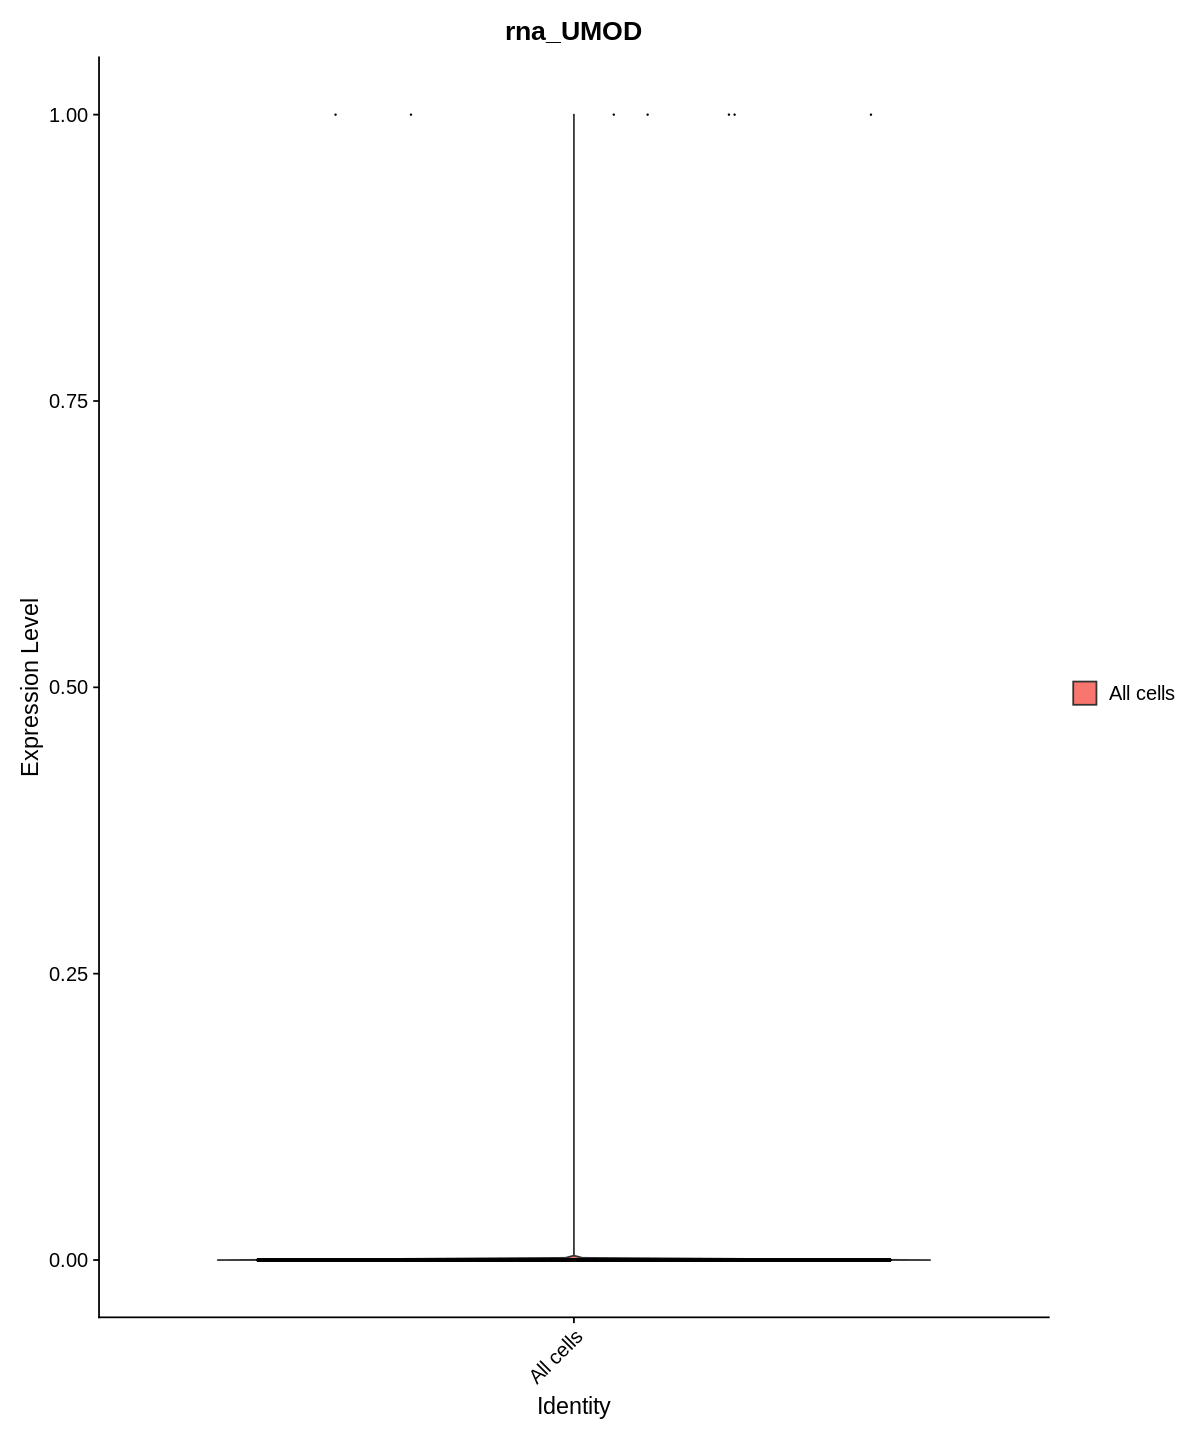

In [238]:
VlnPlot(seurat_combined, assay = 'RNA', features = "rna_UMOD")

# Redundant